<a href="https://colab.research.google.com/github/YanzhaoZ/Data-Analysis/blob/master/Language_base_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [ ]:
import pandas as pd
import glob
import re
import nltk
nltk.download('words')

!pip install yfinance
import yfinance as yf
import numpy as np

!pip install vectorbt
import vectorbt as vbt

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
     |████████████████████████████████| 5.5MB 21.2MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=f554f55f1b2def70a69f0dd46c8936ac7d15f8a21acfa95f618cc8fe727d53aa
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 337kB 17.7MB/s 
     |████████████████████████████████| 13.2MB 222kB/s 
     |████████████████████████████████| 3.4MB 48.2MB/s 
     |████████████████████████████████| 286kB 59.3MB/s 
     |████████████████████████████████| 25.3MB 130kB/s 
  Created wheel for vectorbt: filename=vectorbt-0.17.7-cp37-none-any.whl size=359531 sha256=e67c8991d8773bb2fc46a5925f04ca6403e0b17f3a3c732fa81517e8d2081b

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import time
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, plot_roc_curve, roc_curve, plot_precision_recall_curve, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import seaborn as sns

import itertools
import datetime

# Loading in data 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#now that I have the whole string for the day, I need to do processing first, before spliting them into chunks. 
words = set(nltk.corpus.words.words())
#I need to add in some crypto currency specific words. like Etherum.
#bascailly all the symbols of crypto currencies, I should add a set here. 
cryptowords=(['crypto','cryptocurrency','bitcoin','btc','etherum','eos','eth','xrp','ltc'])
words.update(cryptowords)

exclusionli=['up','so','if','go'] #keep in view


def processTweet(tweetFeed):
    tweetFeed = tweetFeed.lower()
    #Convert www.* or https?://* pic.twitter.com* to space
    tweetFeed = re.sub('(https:\/\/www\.[\s][\a-zA-Z]*)|(http:\/\/www\.[\s][\a-zA-Z]*)|(https:\/\/[\s][\a-zA-Z]*)|(http:\/\/[\s][\a-zA-Z]*)|(www\.[\s][\a-zA-Z]*)|(https:\/\/[\a-zA-Z]*)|(http:\/\/[\a-zA-Z]*)',' ',tweetFeed)
    tweetFeed = re.sub('pic\.[^\s]*',' ',tweetFeed)
    #removw @sth and #sth
    tweetFeed = re.sub('(@\ [^\s]*)|(#\ [^\s]*)', ' ', tweetFeed)
    #remove rt
    tweetFeed = re.sub('rt[\s]','',tweetFeed)

    tweetFeed = " ".join(w for w in nltk.wordpunct_tokenize(tweetFeed) if w.lower() in words)# or not w.isalpha())#this part takes in number as True.
    #I'm not so sure about this language filter, but let's just roll with it first. 
    tweetFeed = re.sub("[^A-Za-z']+", ' ', tweetFeed)

    #filter out all the token left with len of 1. possibaly 2, defind a exclusion list: up, if, so, 
    tweetFeed = " ".join(w for w in nltk.wordpunct_tokenize(tweetFeed) if len(w) >1 )
    return tweetFeed


In [ ]:
#now let's try to split the text into smaller chunks, which is just taking the tutorial's code
def get_split(text1,length=200, overlap=50):
  l_total = []
  l_parcial = []
  if len(text1.split())//(length-overlap) >0:
    n = len(text1.split())//(length-overlap)
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:length]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*(length-overlap):w*(length-overlap) + length]
      l_total.append(" ".join(l_parcial))
  return l_total

In [ ]:
#next, tie them up, read in csv, combine into chunks, take the dates as the price? 
path = '/content/gdrive/My Drive/Crypto/tweets2019'
all_files = glob.glob(path+'/*.csv')

#let me try to use list1 to store string and list 2 to store dates
li1=[]
li2=[]
for file in all_files:
  df=pd.read_csv(file,sep=',',index_col=0)
  df=df['text'].to_frame()
  rawtxt=[]
  for row in df.text:
    rawtxt.append(row)
  string = " ".join(rawtxt)

  date= file[-14:-4]
  
  li1.append(string)
  li2.append(date)

data=pd.DataFrame({'date':li2, 'text':li1})



Thoughts, if the sentence lvl embedding does not depend on the number of tokens present, there's no need to do the chunking? I could just use each entry as it is ? 

In [ ]:
data.head()

,date,text
0,2019-11-27,$ BTC | # BTC - bitcoin's Current Price: ▲ $72...
1,2019-08-12,Prices update in $ USDT (1 hour): $ BTC - 1159...
2,2019-01-22,"仮想通貨の時価総額 $119,391,276,842 BTC 価格:$3577.41 ドミナ..."
3,2019-08-06,Bitcoin early adopters are the doomsday preppe...
4,2019-06-03,$ BTC | # BTC - bitcoin's Current Price: ▲ $87...


In [ ]:
#now, let's process the text with the pre-defined functin. and perhaps add in the label by looking at the price. 
data['clean_txt']=data['text'].apply(processTweet)

#A note for the price, file date is the day after all the tweets inside. So the label should be created, as such that it reflex:
#file date over previous day change. 
#What index should I use/should I use my own file (maybe not, too big/detailed for daily ticker). Let's go with Yahoofinance.
#now, let's create the price change label, return diff, log return diff, and binary label 
start_date ='2018-12-28'
end_date = '2019-12-31'
price = yf.download("BTC-USD", start=start_date, end=end_date)
price_2= price.Close.to_frame()
price['change']=price_2.apply(lambda x: x/x.shift(1)-1)
price['log_change']=price_2.apply(lambda x: np.log(x)-np.log(x.shift(1)))
price['change_label']=price['change'].apply (lambda x: x>0.00)
price=price.reset_index()
price['date']=price.Date.apply (lambda x : str(x)[:10])

[*********************100%***********************]  1 of 1 completed


In [ ]:
price.head()

,Date,Open,High,Low,Close,Adj Close,Volume,change,log_change,change_label,date
0,2018-12-28,3653.131836,3956.135986,3642.632080,3923.918701,3923.918701,5631554348,NaN,NaN,False,2018-12-28
1,2018-12-29,3932.491699,3963.758789,3820.408691,3820.408691,3820.408691,4991655917,-0.026379,-0.026733,False,2018-12-29
2,2018-12-30,3822.384766,3901.908936,3797.219238,3865.952637,3865.952637,4770578575,0.011921,0.011851,True,2018-12-30
3,2018-12-31,3866.839111,3868.742920,3725.867432,3742.700439,3742.700439,4661840806,-0.031881,-0.032401,False,2018-12-31
4,2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990,0.026938,0.026581,True,2019-01-01


In [ ]:
#now that I have everything, I need to join the price set with my text set, by the date column. 
#I have a problem with datetime type on price frame vs string in text date, which converstion should I use, convert to string?  Let
# us convert datetime to string first. if need to, we can do the otherway in the future. 
# import datetime
# t = datetime.datetime(2012, 2, 23, 0, 0)
# t.strftime('%Y-%m-%d')

frame_x = data.merge(price, how='outer', on=['date'])
#and drop any non-overlapping cells by dropna.
frame_x = frame_x.dropna()


In [ ]:
frame_x.head()

,date,text,clean_txt,Date,Open,High,Low,Close,Adj Close,Volume,change,log_change,change_label
0,2019-11-27,$ BTC | # BTC - bitcoin's Current Price: ▲ $72...,btc bitcoin current price more on valid with c...,2019-11-27,7220.880859,7619.693359,6974.174316,7531.663574,7531.663574,23991412764,0.043402,0.042487,True
1,2019-08-12,Prices update in $ USDT (1 hour): $ BTC - 1159...,update in hour btc eth xrp ltc to win the bitc...,2019-08-12,11528.189453,11528.189453,11320.951172,11382.616211,11382.616211,13647198229,-0.012233,-0.012308,False
2,2019-01-22,"仮想通貨の時価総額 $119,391,276,842 BTC 価格:$3577.41 ドミナ...",btc eth btc bitcoin current price more on btc ...,2019-01-22,3575.081299,3620.746582,3539.721436,3604.577148,3604.577148,5313623556,0.007982,0.007951,True
3,2019-08-06,Bitcoin early adopters are the doomsday preppe...,bitcoin early are the doomsday of finance you ...,2019-08-06,11811.544922,12273.821289,11290.731445,11478.168945,11478.168945,23635107660,-0.027740,-0.028132,False
4,2019-06-03,$ BTC | # BTC - bitcoin's Current Price: ▲ $87...,btc bitcoin current price more on if you think...,2019-06-03,8741.747070,8743.500000,8204.185547,8208.995117,8208.995117,22004511436,-0.061073,-0.063018,False


In [ ]:
#take a look at class balance. 
frame_x.change_label.value_counts()

True     191
False    174
Name: change_label, dtype: int64

In [ ]:
#now that I have the frame prepared, I think I should do the text splitting part? 
#I need to decide on the length to use, and embedding to use. 
#let's roll with the 200 length for now. 

frame_x['text_split']=frame_x.clean_txt.apply(get_split)


In [ ]:
frame_x.head()

,date,text,clean_txt,Date,Open,High,Low,Close,Adj Close,Volume,change,log_change,change_label,text_split
0,2019-11-27,$ BTC | # BTC - bitcoin's Current Price: ▲ $72...,btc bitcoin current price more on valid with c...,2019-11-27,7220.880859,7619.693359,6974.174316,7531.663574,7531.663574,23991412764,0.043402,0.042487,True,[btc bitcoin current price more on valid with ...
1,2019-08-12,Prices update in $ USDT (1 hour): $ BTC - 1159...,update in hour btc eth xrp ltc to win the bitc...,2019-08-12,11528.189453,11528.189453,11320.951172,11382.616211,11382.616211,13647198229,-0.012233,-0.012308,False,[update in hour btc eth xrp ltc to win the bit...
2,2019-01-22,"仮想通貨の時価総額 $119,391,276,842 BTC 価格:$3577.41 ドミナ...",btc eth btc bitcoin current price more on btc ...,2019-01-22,3575.081299,3620.746582,3539.721436,3604.577148,3604.577148,5313623556,0.007982,0.007951,True,[btc eth btc bitcoin current price more on btc...
3,2019-08-06,Bitcoin early adopters are the doomsday preppe...,bitcoin early are the doomsday of finance you ...,2019-08-06,11811.544922,12273.821289,11290.731445,11478.168945,11478.168945,23635107660,-0.027740,-0.028132,False,[bitcoin early are the doomsday of finance you...
4,2019-06-03,$ BTC | # BTC - bitcoin's Current Price: ▲ $87...,btc bitcoin current price more on if you think...,2019-06-03,8741.747070,8743.500000,8204.185547,8208.995117,8208.995117,22004511436,-0.061073,-0.063018,False,[btc bitcoin current price more on if you thin...


In [ ]:
frame_x.shape

(365, 14)

In [ ]:
#ok, i'm gonna rank the frame here by the time entry. 
frame_x= frame_x.sort_values('date',ascending=True)

In [ ]:
#try to save the processed frame to load directly next time
df_save=frame_x[['date','text_split','change_label']]

In [ ]:
#df_save = pd.read_csv('/content/gdrive/My Drive/Crypto/df_save_2019.csv',sep =',', index_col =0)
df_save.head()
#df_save.to_csv('/content/gdrive/My Drive/Crypto/df_save_2019.csv',index=False)

#can't save here btw, the saving/loading screwed up the chunking format, makes the model read character by chracter, instead of chunk by chunk later on .

,date,text_split,change_label
316,2019-01-01,[bitcoin could revolutionize governance accord...,True
289,2019-01-02,[btc over now bitcoin cash pay the up threaten...,True
276,2019-01-03,[btc bitcoin price in on resistance at will th...,False
345,2019-01-04,[na data de era do da btc san bitcoin how bitc...,True
320,2019-01-05,[tell my year old self to act less edgy and to...,False


In [ ]:
#just checking the number of chunks each day, to get a general idea. 
list = []
for i in range (364):
  list.append(np.shape(df_save.text_split[i])[0])

In [ ]:
[i for i,x in enumerate(list) if x==11] #so the 186th entry only has 11 tweets. meaning that day is screwed up. 

[186]

In [ ]:
list.sort()
list
# yea there're 2-3 days that's quite the outlier...shouldn't affect too much though?  

[11,
 73,
 95,
 154,
 180,
 181,
 194,
 213,
 217,
 218,
 220,
 222,
 222,
 223,
 223,
 223,
 235,
 238,
 239,
 239,
 244,
 245,
 246,
 247,
 247,
 247,
 247,
 248,
 248,
 249,
 250,
 251,
 252,
 254,
 254,
 254,
 254,
 255,
 255,
 255,
 256,
 256,
 257,
 257,
 257,
 257,
 258,
 258,
 259,
 259,
 260,
 260,
 261,
 261,
 261,
 261,
 261,
 262,
 262,
 262,
 262,
 262,
 262,
 263,
 263,
 263,
 264,
 264,
 265,
 265,
 265,
 265,
 265,
 265,
 265,
 265,
 266,
 266,
 266,
 266,
 266,
 266,
 267,
 268,
 268,
 269,
 269,
 269,
 270,
 270,
 270,
 270,
 270,
 270,
 271,
 271,
 271,
 271,
 272,
 272,
 272,
 272,
 272,
 273,
 273,
 273,
 273,
 273,
 273,
 273,
 273,
 274,
 274,
 274,
 274,
 274,
 275,
 275,
 275,
 275,
 275,
 276,
 276,
 276,
 276,
 276,
 276,
 276,
 277,
 277,
 277,
 277,
 277,
 278,
 278,
 278,
 278,
 279,
 279,
 279,
 279,
 279,
 279,
 279,
 280,
 280,
 280,
 280,
 280,
 280,
 281,
 281,
 281,
 281,
 281,
 281,
 281,
 282,
 282,
 282,
 282,
 282,
 283,
 283,
 283,
 283,
 283,
 

In [ ]:
#ok, now, let's save another version, with every chunk as an entry. 
#this part, omits the dates signal for now. btw 
train_l = []
label_l = []
index_l =[]
for idx,row in df_save.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['change_label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

#on second thought, I'm basically assigning the daily overall label, onto possibly negative entries. 
#I don't think this helps with the model learning? It can be very confusing. 

#so, if I'm processing for CNN input, it should be done here 

(104161, 104161, 104161)

In [ ]:
np.shape(df_save.text_split[0])

(308,)

But if this is how I splited the chunks, it's almost like I redivided daily tweets into length of 200. just for the sake of processing??? One day of tweets, even though given the same label, could have very diff sentiment, in the middle. Am i not confusing the model??? And the validation prediction will be multiple for 1 day of tweets, contradicting each other...how is this a meaningful set up ??? 

In [ ]:
#converting the label from True/False to 1/0. might be redundant, see how. 
label_l_num= [1 if row == True else 0 for row in label_l]

train_df = pd.DataFrame({'text_split':train_l, 'change_label':label_l_num})

#ok, I'm going to split my dataframe into train/validation by a percentage
frame_len= train_df.shape[0]
split_ratio= 0.7
num = round(frame_len * split_ratio)

#going to save the train_df, and the train/val split into files, for easier acess across notebooks. 

train_df[:num].to_csv('/content/gdrive/My Drive/Crypto/train_save.csv',index=False)
train_df[num:].to_csv('/content/gdrive/My Drive/Crypto/val_save.csv',index=False)


In [ ]:
train_df[:num].head()

,text_split,change_label
0,bitcoin could revolutionize governance accordi...,1
1,be sparkling clean with all the wash trading g...,1
2,the in the last bitcoin price did not behave a...,1
3,above it for bitcoin on track to replace gold ...,1
4,la de ser en global network in helping those w...,1


In [ ]:
#train_df[num:].change_label.value_counts()
train_df[num:].change_label.sum()/len(train_df[num:])

0.42889144905273935

In [ ]:
!ls '/content/gdrive/My Drive/Crypto'

dailynum_2019.pt       df_save.csv
dailynum_apr_dec.pt    embeddings
dailynum_jan_march.pt  final_price_2019.csv
df2_save.csv	       GoogleNews-vectors-negative300.bin.gz
df3_save.csv	       train_save.csv
df4_save.csv	       tweets2019
df_save_2019.csv       val_save.csv


# Get word embeddings

In [ ]:
#ok text and labels are somewhat prepared, time to bring out the big guns,get the embedding. 
#USE PRETRAINED ONES, what embeddings to use. doesn't have to be BERT. 

#in the BERT tutorial mode, there are a few steps:
#1. prepare data for Bert
#2. finetune Bert
#3. extract Bert embedding
#4. prepare the emedding to LSTM, which takes in variable input length, gotta do padding and masking and stuff. 


In [ ]:
import torch
from torchtext import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

#from torchtext import datasets

#train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [ ]:
#example = next(iter(test_data))

In [ ]:
#field = {'date':('date',TEXT),'text_split':('text_split',TEXT),'change_label':('change_label',LABEL)}
#maybe i'll leave out the date first. 
field = {'text_split':('text_split',TEXT),'change_label':('change_label',LABEL)}
#field = {'date':('date',TEXT), 'change_label':('change_label',LABEL)}
#field = {'change_label':('change_label',LABEL)}

#I need to do something about the 'text_split' field with this tokenizer, the processing might to be done before hand. 

In [ ]:
train_1, val_1 = data.TabularDataset.splits(path='/content/gdrive/My Drive/Crypto/',train='train_save.csv',validation='val_save.csv',format='csv',fields=field)

In [ ]:
#this step is apparently not needed if my sentence is not gazillion long. 
import sys
import csv

csv.field_size_limit(sys.maxsize)


9223372036854775807

In [ ]:
print (val_1[0].__dict__.keys())

dict_keys(['text_split', 'change_label'])


In [ ]:
print (val_1[4600].__dict__.values())

dict_values([['don', 'trade', 'good', 'luck', 'to', 'you', 'all', 'even', 'salty', 'bear', 'later', 'alert', 'outside', 'project', 'fast', 'scam', 'beware', 'after', 'days', 'plan', 'cycle', 'is', 'over', 'and', 'min', 'deposit', 'raised', 'en', 'sabe', 'de', 'no', 'solo', 'las', 'sound', 'money', 'de', 'bitcoin', 'al', 'fiat', 'las', 'la', 'el', 'sov', 'es', 'de', 'hard', 'money', 'el', 'bitcoin', 'es', 'de', 'us', 'there', 'is', 'an', 'incentive', 'for', 'that', 'have', 'heavily', 'in', 'and', 'faster', 'mining', 'equipment', 'to', 'on', 'the', 'price', 'of', 'bitcoin', 'doing', 'so', 'out', 'the', 'which', 'maximize', 'the', 'number', 'of', 'bitcoin', 'ilk', 'practice', 'the', 'power', 'of', 'mining', 'and', 'development', 'the', 'crypto', 'space', 'is', 'golden', 'opportunity', 'for', 'all', 'that', 'simply', 'get', 'involved', 'support', 'contribute', 'and', 'adopt', 'praise', 'another', 'have', 'been', 'found', 'be', 'thankful', 'for', 'every', 'block', 'block', 'hash', 'ist', 'm

In [ ]:
df= pd.read_csv('/content/gdrive/My Drive/Crypto/val_save.csv')
df[4600:4603]

,text_split,change_label
4600,don trade good luck to you all even salty bear...,0
4601,link in description long bitcoin btc price bit...,0
4602,easier and more attractive for people to inves...,0


In [ ]:
#next(iter(train_1)).text_split
#so the text_split part, is a list. of al the tokens i recon, and '[' is even tokenized as well. 
#now it looks somewhat normal. 

In [ ]:
#now let's try out the build vocabulary part

MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_1, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_) # how to initialize unseen words not in glove

LABEL.build_vocab(train_1)

In [ ]:
TEXT.pad_token

'<pad>'

In [ ]:
#check the vocba size
len(TEXT.vocab)

25002

In [ ]:
#so...now that I've built the vocab, how do I check? obviously this vocab will not be very crypto currency friendly. 
#so ideally it should also be fine tuned. but let's get on with it for now. 

In [ ]:
BATCH_SIZE = 64

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda'



In [ ]:
torch.cuda.is_available()

True

In [ ]:
train_iterator, val_iterator = data.BucketIterator.splits(
    (train_1,val_1), 
    batch_size = BATCH_SIZE,
    #sort_within_batch = True,
    sort_key=lambda x: len(x.text_split), # the BucketIterator needs to be told what function it should use to group the data.
    sort_within_batch=False,
    device = device)

#error msg: Example' object has no attribute 'sort_key'
#stackoverflow says fields are not passed in the same order as they are in the csv/tsv file
#tried to convert labels from true/false to 1/0, didn't solve the error. 
#check values, nothing is null. how to solve this buuuuug. HALP!!!

#...ok, I don't need to split, if, i'm only iterating over train_l data...ok work! 

In [ ]:
# train_iterator = data.BucketIterator.splits(
#     train_1, 
#     batch_size = BATCH_SIZE,
#     #sort_within_batch = True,
#     sort_key=lambda x: len(x.text_split), # the BucketIterator needs to be told what function it should use to group the data.
#     sort_within_batch=False,
#     device = device)

# train_iterator[64].__dict__

In [ ]:
#seems like the sequnce is kept, which is just what I want, great. 

# train_iterator[0].dataset.text_split[0:10]

# Get into the model

In [ ]:
##now, let's get into the modeling part 
#1. defining the model
#2. writting out the training loop 


In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self,vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
      super().__init__()
      self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
      self.rnn = nn.LSTM(embedding_dim,
                         hidden_dim,
                         num_layers=n_layers,
                         bidirectional=bidirectional,
                         dropout=dropout)
      self.fc = nn.Linear(hidden_dim*2, output_dim)
      self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
      embedded = self.dropout(self.embedding(text))
      
      packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, enforce_sorted = False) #added the enforce_sorted = false, debug
      packed_output, (hidden, cell) = self.rnn(packed_embedded)

      output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)#btw this is not used here i think.

      hidden = self.dropout(torch.cat((hidden[-2,:,:],hidden [-1,:,:]),dim =1 ))

      return self.fc(hidden)


      

In [ ]:
INPUT_DIM=len(TEXT.vocab)
EMBEDDING_DIM=100
HIDDEN_DIM=256
OUTPUT_DIM = 1
N_LAYERS=2
BIDIRECTIONAL=True
DROPOUT = 0.5
PAD_IDX= TEXT.vocab.stoi[TEXT.pad_token]

#i really donno what's the pad_token thing here...or how to use/where to learn vocab.stoi 
#TEXT.pad_token is just the dictionary key to the padding token, which is <pad> here.
#and TEXT.vocab.stoi['<pad>'] gives the padding value, 1. 
model = RNN(INPUT_DIM,EMBEDDING_DIM,HIDDEN_DIM,OUTPUT_DIM,N_LAYERS,BIDIRECTIONAL,DROPOUT,PAD_IDX)




In [ ]:
#checking trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,810,857 trainable parameters


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [ ]:
#copying the pretrained weights into the embedding. 
model.embedding.weight.data.copy_(pretrained_embeddings)


#i'm a little bit confused about this part for sure..why copying weights? then the embeddings is what? 
#so embedding layer is just like a dictionary with word index and as the key, values are just hte "weights"
#if i dont'wnat the weigts to be touched, I can specify in the model as
# print("Do not finetune word embedding layer.")
#             self.emb.weight.requires_grad = False


tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [ 0.8403,  0.1327, -0.6158,  ...,  0.7602, -0.2352,  0.3349],
        ...,
        [-0.0036,  0.5274,  0.0508,  ..., -0.4852, -0.2283,  0.4557],
        [-0.1859,  0.1002,  0.5297,  ..., -0.3461, -0.4341,  0.9542],
        [ 0.2712, -0.1479, -0.0515,  ..., -0.2387, -0.7476, -0.1554]])

In [ ]:
#this step will set the <unk> and <pad> to be 0, and make them irrelevant for the model
#is this good though? the pretrained model is not on crypto words, which means the model WILL ignore crypto words
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.8403,  0.1327, -0.6158,  ...,  0.7602, -0.2352,  0.3349],
        ...,
        [-0.0036,  0.5274,  0.0508,  ..., -0.4852, -0.2283,  0.4557],
        [-0.1859,  0.1002,  0.5297,  ..., -0.3461, -0.4341,  0.9542],
        [ 0.2712, -0.1479, -0.0515,  ..., -0.2387, -0.7476, -0.1554]],
       device='cuda:0')


# Now Train the Model

In [ ]:
#choose optimizer 
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [ ]:
#moving to GPU. 
criterion = nn.BCEWithLogitsLoss()

model= model.to(device)
criterion = criterion.to(device)

In [ ]:
device

'cuda'

In [ ]:
#defining accuracy metrics
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
#can i define a function to calculate the f1 score/confusion matrix? 
def get_cfm (pred, label):
    #_,pred_label = torch.max(pred,dim=1)
    rounded_preds = torch.round(torch.sigmoid(pred))
    m = classification_report(rounded_preds, label.cpu())
    return m


In [ ]:
#note, here we seperate the text and text.length as they are tuple

def train(model,iterator,optimizer, criterion):
  epoch_loss = 0 
  epoch_acc = 0

  model.train() #so that droput function works 
  for batch in iterator: 
    optimizer.zero_grad()#why? ok, to not accumulate un-intended gradient i guess.

    text, text_lengths = batch.text_split
    #predictions = model(text, text_lengths).squeeze(1) #why the fk do i need to move the length to cpu. 
    predictions = model(text, text_lengths.cpu()).squeeze(1) #what's the squeeze, what does squeeze do? pack np.array to be lower dimension?
    loss = criterion(predictions, batch.change_label)

    acc = binary_accuracy(predictions, batch.change_label)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(iterator) , epoch_acc / len(iterator)



In [ ]:
def evaluate(model, iterator, criterion):

  epoch_loss = 0 
  epoch_acc = 0

  model.eval() #so that droput function DONT ACTIVATE

  pred_list = []
  label_list = []
  step = 0 
  with torch.no_grad():
  #is this what we do for evaluation always? 
  #answer: "with torch.no_grad()" temporarily set all the requires_grad flag to false.
    for batch in iterator: 

      text, text_lengths = batch.text_split
      #predictions = model(text, text_lengths).squeeze(1) #what's the squeeze, what does squeeze do? pack np.array to be lower dimension?
      predictions = model(text, text_lengths.cpu()).squeeze(1)
      loss = criterion(predictions, batch.change_label)

      acc = binary_accuracy(predictions, batch.change_label)

      if step ==0:     
          pred_list=predictions.cpu().detach().numpy()
          label_list = batch.change_label.cpu().detach().numpy()
      if step != 0:
          pred_list = np.concatenate([pred_list,predictions.cpu().detach().numpy()],axis =0)
          label_list = np.concatenate([label_list,batch.change_label.cpu().detach().numpy()],axis =0)
      step = step + 1

      epoch_loss += loss.item()
      epoch_acc += acc.item()

    report = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report)
  return epoch_loss / len(iterator) , epoch_acc / len(iterator)


        



In [ ]:
#define a timing function 
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:

#now try to train yea
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

TypeError: ignored

In [ ]:
#now try to train yea
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

# Test FINBERT embedding

## load in the finbert tensors

In [ ]:
#loading 2015-2019 embeddings.

#li_loaded = torch.load('/content/gdrive/My Drive/Crypto/test_tensor_2019.pt')
path = '/content/gdrive/My Drive/Crypto/embeddings'
all_files = glob.glob(path+'/*.pt')
li =[]
li_tensor = []

for file in all_files:
  li.append(file)

li.sort()
for item in li:
  loaded = torch.load(item)
  li_tensor = list(itertools.chain(li_tensor,loaded)) #followed examples here: https://stackoverflow.com/questions/3021641/concatenation-of-many-lists-in-python
  

In [ ]:
li

['/content/gdrive/My Drive/Crypto/embeddings/test_tensor_2015_jan_dec.pt',
 '/content/gdrive/My Drive/Crypto/embeddings/test_tensor_2016_jan_dec.pt',
 '/content/gdrive/My Drive/Crypto/embeddings/test_tensor_2017_jan_dec.pt',
 '/content/gdrive/My Drive/Crypto/embeddings/test_tensor_2018_jan_dec.pt',
 '/content/gdrive/My Drive/Crypto/embeddings/test_tensor_2019.pt']

In [ ]:
#laod 2019 embeddings only
# item = '/content/gdrive/My Drive/Crypto/embeddings/test_tensor_2019.pt'

# li_tensor = torch.load(item)
  

In [ ]:
#len(li_tensor)
#li_tensor[0].shape
len(li_tensor)

269111

In [ ]:
#li

In [ ]:
#torch.save(li_tensor,'/content/gdrive/My Drive/Crypto/embeddings/test_tensor_2019.pt')

## split them by daily entries. 

In [ ]:
#load 2019 daily num entry only
# daily_num = torch.load('/content/gdrive/My Drive/Crypto/dailynum/dailynum_2019.pt')

In [ ]:
#loading 2015-2019 embeddings.


path = '/content/gdrive/My Drive/Crypto/dailynum'
all_files = glob.glob(path+'/*.pt')
li =[]
daily_num = []

for file in all_files:
  li.append(file)

li.sort()
for item in li:
  loaded = torch.load(item)
  print (len(loaded))
  daily_num = list(itertools.chain(daily_num,loaded)) #followed examples here: https://stackoverflow.com/questions/3021641/concatenation-of-many-lists-in-python

364
364
364
363
365


In [ ]:
li

['/content/gdrive/My Drive/Crypto/dailynum/dailynum_2015_jan_dec.pt',
 '/content/gdrive/My Drive/Crypto/dailynum/dailynum_2016_jan_dec.pt',
 '/content/gdrive/My Drive/Crypto/dailynum/dailynum_2017_jan_dec.pt',
 '/content/gdrive/My Drive/Crypto/dailynum/dailynum_2018_jan_dec.pt',
 '/content/gdrive/My Drive/Crypto/dailynum/dailynum_2019.pt']

In [ ]:
len(daily_num)
#this number seems wrong. 5 years should have more days. 

1820

In [ ]:
sum(daily_num)
#make sure the sum is the same as the len of the li_tensor, to ensure entry match. 

269111

In [ ]:
prev=0
later = 0
daily_li=[]
for i in daily_num:
  later = prev + i 
  daily_li.append(li_tensor[prev:later])
  prev = later 
#checked, seems to be good.

But then, how am i going to stack them up, and prepare for CNN input next ummm.

In [ ]:
test_tensor = torch.stack(daily_li[0],dim = 0)

In [ ]:
test_tensor.shape

torch.Size([64, 768])

In [ ]:
a = torch.tensor([1,2,3])

In [ ]:
b = torch.tensor([0,0,0])

In [ ]:
torch.stack((a,b,b),dim=0)

tensor([[1, 2, 3],
        [0, 0, 0],
        [0, 0, 0]])

## now prepare for CNN input 

In [ ]:
#check the max entry per day 
daily_max = max(daily_num)
print (daily_max)

362


In [ ]:
#write function to create padding: 
def pad_input(daily_li, daily_num, daily_max):
  padded_embeddings = [] 
  pad_num = [daily_max - i for i in daily_num] 
  for i in range(len(daily_li)):
    #create a list of 0 tensors.
    zero_tensors = [torch.zeros(768) for x in range (pad_num[i])]
    #concat daily entry list with the zero entry list 
    daily_combine = list(itertools.chain(daily_li[i],zero_tensors))
    #stack the tensors tgt
    daily_tensor = torch.stack(daily_combine, dim = 0)
    padded_embeddings.append(daily_tensor)
  
  return padded_embeddings
  

In [ ]:
padded = pad_input(daily_li, daily_num, daily_max)
#seems to be working well 

In [ ]:
padded[50].size()

torch.Size([362, 768])

## now process the price labels for the dates (skippable after 1 execution)

In [ ]:
#first, need to get y labels. 
#this part is close price, over close price comparison
# start_date ='2018-12-31'
# end_date = '2019-12-31'
# price = yf.download("BTC-USD", start=start_date, end=end_date)
# price_2= price.Close.to_frame()
# price['change']=price_2.apply(lambda x: x/x.shift(1)-1)
# price['log_change']=price_2.apply(lambda x: np.log(x)-np.log(x.shift(1)))

# #change percentage is specified here: 
# price['change_label']=price['change'].apply (lambda x: x>0.05)
# #########################################

# price=price.reset_index()
# price = price.dropna()
# price['date']=price.Date.apply (lambda x : str(x)[:10])


In [ ]:
#create label for high price over close price, comparison.
#also exclude last day in 2015-2018, and 2018-07-20
start_date ='2014-12-31'
end_date = '2020-01-01'
price = yf.download("BTC-USD", start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


In [ ]:
price_2= price.High.to_frame()
price_2= price_2.shift(-1)

In [ ]:
price_y = price.merge(price_2, how='outer', on=['Date'])

In [ ]:
price_y.head()

,Open,High_x,Low,Close,Adj Close,Volume,High_y
Date,,,,,,,
2014-12-31,310.914001,320.192993,310.210999,320.192993,320.192993,13942900,320.434998
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,315.838989
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,315.149994
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,287.230011
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,278.341003


In [ ]:
price_y['change']=price_y.High_y/price_y.Close -1

In [ ]:
price_y.tail()

,Open,High_x,Low,Close,Adj Close,Volume,High_y,change
Date,,,,,,,,
2019-12-28,7289.031250,7399.041016,7286.905273,7317.990234,7317.990234,21365673026,7513.948242,0.026778
2019-12-29,7317.647461,7513.948242,7279.865234,7422.652832,7422.652832,22445257702,7454.824219,0.004334
2019-12-30,7420.272949,7454.824219,7276.308105,7292.995117,7292.995117,22874131672,7335.290039,0.005799
2019-12-31,7294.438965,7335.290039,7169.777832,7193.599121,7193.599121,21167946112,7254.330566,0.008442
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997,NaN,NaN


In [ ]:
price_y = price_y.dropna()
#and also drop the missing dates
price_y= price_y.reset_index()

In [ ]:
#0,365,585,731,1096,1297,1461
price_y2 = price_y.drop([0,365,585,731,1096,1297,1461])
len(price_y2)

1820

In [ ]:
price_y2.tail()

,Date,Open,High_x,Low,Close,Adj Close,Volume,High_y,change
1822,2019-12-27,7238.141113,7363.529297,7189.934082,7290.088379,7290.088379,22777360996,7399.041016,0.014945
1823,2019-12-28,7289.031250,7399.041016,7286.905273,7317.990234,7317.990234,21365673026,7513.948242,0.026778
1824,2019-12-29,7317.647461,7513.948242,7279.865234,7422.652832,7422.652832,22445257702,7454.824219,0.004334
1825,2019-12-30,7420.272949,7454.824219,7276.308105,7292.995117,7292.995117,22874131672,7335.290039,0.005799
1826,2019-12-31,7294.438965,7335.290039,7169.777832,7193.599121,7193.599121,21167946112,7254.330566,0.008442


In [ ]:
price_y2.to_csv('/content/gdrive/My Drive/Crypto/price_2015_2019.csv',index=False)


## now process the price labels for the dates (skippable after 1 execution)(DOWNWARDS PREDICTION)

In [ ]:
#first, need to get y labels. 
#this part is close price, over close price comparison
# start_date ='2018-12-31'
# end_date = '2019-12-31'
# price = yf.download("BTC-USD", start=start_date, end=end_date)
# price_2= price.Close.to_frame()
# price['change']=price_2.apply(lambda x: x/x.shift(1)-1)
# price['log_change']=price_2.apply(lambda x: np.log(x)-np.log(x.shift(1)))

# #change percentage is specified here: 
# price['change_label']=price['change'].apply (lambda x: x>0.05)
# #########################################

# price=price.reset_index()
# price = price.dropna()
# price['date']=price.Date.apply (lambda x : str(x)[:10])


In [ ]:
#create label for high price over close price, comparison.
#also exclude last day in 2015-2018, and 2018-07-20
start_date ='2014-12-31'
end_date = '2020-01-01'
price = yf.download("BTC-USD", start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


In [ ]:
price_2= price.Low.to_frame()
price_2= price_2.shift(-1)

In [ ]:
price_y = price.merge(price_2, how='outer', on=['Date'])

In [ ]:
price_y.head()

,Open,High,Low_x,Close,Adj Close,Volume,Low_y
Date,,,,,,,
2014-12-31,310.914001,320.192993,310.210999,320.192993,320.192993,13942900,314.002991
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,313.565002
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,281.082001
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,257.612000
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,265.084015


In [ ]:
price_y['change']=price_y.Low_y/price_y.Close -1

In [ ]:
price_y.tail()

,Open,High,Low_x,Close,Adj Close,Volume,Low_y,change
Date,,,,,,,,
2019-12-28,7289.031250,7399.041016,7286.905273,7317.990234,7317.990234,21365673026,7279.865234,-0.005210
2019-12-29,7317.647461,7513.948242,7279.865234,7422.652832,7422.652832,22445257702,7276.308105,-0.019716
2019-12-30,7420.272949,7454.824219,7276.308105,7292.995117,7292.995117,22874131672,7169.777832,-0.016895
2019-12-31,7294.438965,7335.290039,7169.777832,7193.599121,7193.599121,21167946112,7174.944336,-0.002593
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997,NaN,NaN


In [ ]:
price_y = price_y.dropna()
#and also drop the missing dates
price_y= price_y.reset_index()

In [ ]:
#0,365,585,731,1096,1297,1461
price_y2 = price_y.drop([0,365,585,731,1096,1297,1461])
len(price_y2)

1820

In [ ]:
price_y2.tail()

,Date,Open,High,Low_x,Close,Adj Close,Volume,Low_y,change
1822,2019-12-27,7238.141113,7363.529297,7189.934082,7290.088379,7290.088379,22777360996,7286.905273,-0.000437
1823,2019-12-28,7289.031250,7399.041016,7286.905273,7317.990234,7317.990234,21365673026,7279.865234,-0.005210
1824,2019-12-29,7317.647461,7513.948242,7279.865234,7422.652832,7422.652832,22445257702,7276.308105,-0.019716
1825,2019-12-30,7420.272949,7454.824219,7276.308105,7292.995117,7292.995117,22874131672,7169.777832,-0.016895
1826,2019-12-31,7294.438965,7335.290039,7169.777832,7193.599121,7193.599121,21167946112,7174.944336,-0.002593


In [ ]:
price_y2.to_csv('/content/gdrive/My Drive/Crypto/price_2015_2019_downward.csv',index=False)


## now create dataset and iterators

In [ ]:
#df = pd.read_csv('/content/gdrive/My Drive/Crypto/price_2015_2019.csv')
#df = pd.read_csv('/content/gdrive/My Drive/Crypto/price_2015_2019_forfusion.csv')
df = pd.read_csv('/content/gdrive/My Drive/Crypto/price_2015_2019_downward.csv')
df.head()

,Date,Open,High,Low_x,Close,Adj Close,Volume,Low_y,change
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,313.565002,-0.002177
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,281.082001,-0.107767
2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,257.612000,-0.083499
3,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,265.084015,0.003365
4,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,272.696014,-0.006478


In [ ]:
df.tail()

,Date,Open,High,Low_x,Close,Adj Close,Volume,Low_y,change
1815,2019-12-27,7238.141113,7363.529297,7189.934082,7290.088379,7290.088379,22777360996,7286.905273,-0.000437
1816,2019-12-28,7289.031250,7399.041016,7286.905273,7317.990234,7317.990234,21365673026,7279.865234,-0.005210
1817,2019-12-29,7317.647461,7513.948242,7279.865234,7422.652832,7422.652832,22445257702,7276.308105,-0.019716
1818,2019-12-30,7420.272949,7454.824219,7276.308105,7292.995117,7292.995117,22874131672,7169.777832,-0.016895
1819,2019-12-31,7294.438965,7335.290039,7169.777832,7193.599121,7193.599121,21167946112,7174.944336,-0.002593


In [ ]:
df.shape

(1820, 9)

In [ ]:
#setting the label threadhold here, and take a look at balance. 
#df['change_label']=df['change'].apply (lambda x: x>0.05)
df['change_label']=df['change'].apply (lambda x: x<-0.05)

In [ ]:
df.change_label.value_counts()

False    1598
True      222
Name: change_label, dtype: int64

In [ ]:
#I think it's better to save it and load it. 

In [ ]:
class ClassifierDataset(Dataset):
    def __init__(self,li, df):
        self.X = li
        self.df = df
        self.Y = self.clean_df()


    def __len__(self):
        return len(self.Y)


    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


    def clean_df(self):
        #drop NaN values, and also load the values into torch.tensor. 
        y_values = self.df.change_label.values


        return torch.from_numpy(y_values).long()


In [ ]:
# define a function for train_test split, and initiate dataset? 
def split_train_test (df, threshold):
    length = len(df)
    split_number  = round(threshold*length)
    return df[0:split_number], df[split_number:]

In [ ]:
len(padded)== len(df)

True

In [ ]:
padded_train, padded_eval = split_train_test(padded, 0.7)
price_train, price_eval = split_train_test(df,0.7)


In [ ]:
price_train.change_label.value_counts()


False    1109
True      165
Name: change_label, dtype: int64

In [ ]:

price_eval.change_label.value_counts()

False    489
True      57
Name: change_label, dtype: int64

In [ ]:
#manuel train test split, oct-dec as eval set. 

# padded_train, padded_eval = padded[0:273], padded[273:]
# price_train, price_eval = price[1:274],price[274:]

In [ ]:
train_dataset = ClassifierDataset(padded_train, price_train)
eval_dataset = ClassifierDataset(padded_eval, price_eval)

In [ ]:
train_dataset[0][0].type()

'torch.FloatTensor'

In [ ]:
train_dataset[0][1].type()

'torch.LongTensor'

In [ ]:
#create iterator
# train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True )
# eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle = True)

In [ ]:
#create an iterator for FUSION WITH NON-SHUFFLE FOR NOW.
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=False )
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle = False)

## if stratified sampling dataloader

In [ ]:
#obtain the label list. 
target_list = []
for _,t in train_dataset:
  target_list.append(t)

#obtain the class weights
leng = len(target_list)
total_true = sum(target_list)
class_count = [leng-total_true, total_true]
class_weight = 1./torch.tensor(class_count, dtype=torch.float)
class_weight

#a weight for each sample
class_weights_all = class_weight[target_list]

weighted_sampler = WeightedRandomSampler(
    weights = class_weights_all,
    num_samples = leng,
    replacement = True
)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 64, sampler=weighted_sampler )
eval_loader = DataLoader(eval_dataset, batch_size = 64, )
# add in shuffle/sampler options later

## now run the model

In [ ]:
class CNN1d(nn.Module):
    def __init__(self, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout):
        
        super().__init__()
        
        #self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
        
        embedded = text
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.permute(0, 2, 1)
        
        #embedded = [batch size, emb dim, sent len]
        
        conved = [F.relu(conv(embedded)) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [ ]:

EMBEDDING_DIM = 768
N_FILTERS = 768
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 2
DROPOUT = 0.5


model = CNN1d(EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,084,802 trainable parameters


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
#criterion = FocalLoss(gamma=1, alpha=0.25)
criterion = FocalLoss(gamma=2, alpha=0.2)

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters())

#criterion = nn.CrossEntropyLoss()


model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

#define a function to calcualte prediction accuracy
def accuracy(pred,label):
    m = nn.Softmax(dim=1)
    _,pred_label = torch.max(m(pred),dim=1)
    correct = (pred_label==label).float()
    accuracy = correct.sum()/len(correct)
    return accuracy

#can i define a function to calculate the f1 score/confusion matrix? 
def get_cfm (pred, label):
    m = nn.Softmax(dim=1)
    _,pred_label = torch.max(m(pred),dim=1)
    mm = classification_report(label.cpu(),pred_label.cpu())
    m = confusion_matrix(label.cpu(),pred_label.cpu())
    return mm, m 



In [ ]:
def train(model, dataloader, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    pred_list =[]
    label_list =[]

    model.train()
    
    for step,batch in enumerate(dataloader):
        
        optimizer.zero_grad()
        
        data, label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        predictions = model(data).squeeze(1)
        
        loss = criterion(predictions, label)
        
        acc = accuracy(predictions, label)

        
        if step ==0:     
            pred_list=predictions.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,predictions.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)


        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    report1, report2 = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report1, report2)   
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader),pred_list,label_list

In [ ]:
def evaluate(model, dataloader,  criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    pred_list =[]
    label_list =[]

    model.eval()
    with torch.no_grad():
      for step,batch in enumerate(dataloader):

          
          data, label = (t for t in batch)
          data = data.to(device)
          label = label.to(device)

          predictions = model(data).squeeze(1)
          
          loss = criterion(predictions, label)
          
          acc = accuracy(predictions, label)

          
          if step ==0:     
              pred_list=predictions.cpu().detach().numpy()
              label_list = label.cpu().detach().numpy()
          if step != 0:
              pred_list = np.concatenate([pred_list,predictions.cpu().detach().numpy()],axis =0)
              label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)
          
          epoch_loss += loss.item()
          epoch_acc += acc.item()

    report1, report2 = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report1, report2)   

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader),pred_list,label_list

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:

N_EPOCHS = 30

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc,pred1,label1 = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc,pred2,label2 = evaluate(model, eval_loader, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

              precision    recall  f1-score   support

           0       0.93      0.66      0.77      1109
           1       0.23      0.67      0.34       165

    accuracy                           0.66      1274
   macro avg       0.58      0.66      0.55      1274
weighted avg       0.84      0.66      0.71      1274
 [[727 382]
 [ 54 111]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       489
           1       0.10      1.00      0.19        57

    accuracy                           0.11       546
   macro avg       0.55      0.50      0.10       546
weighted avg       0.91      0.11      0.02       546
 [[  1 488]
 [  0  57]]
Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 0.185 | Train Acc: 65.52%
	 Val. Loss: 0.050 |  Val. Acc: 10.22%
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1109
           1       0.21      0.36      0.27       165

    accuracy                

In [ ]:
# torch.save(pred1,'/content/gdrive/My Drive/Crypto/pred1_downward.pt')
# torch.save(pred2,'/content/gdrive/My Drive/Crypto/pred2_downward.pt')
# torch.save(label1,'/content/gdrive/My Drive/Crypto/label1_downward.pt')
# torch.save(label2,'/content/gdrive/My Drive/Crypto/label2_downward.pt')

In [ ]:
# torch.save(pred1,'/content/gdrive/My Drive/Crypto/pred1_gamma1.pt')
# torch.save(pred2,'/content/gdrive/My Drive/Crypto/pred2_gamma1.pt')
# torch.save(label1,'/content/gdrive/My Drive/Crypto/label1_gamma1.pt')
# torch.save(label2,'/content/gdrive/My Drive/Crypto/label2_gamma1.pt')

## try sample CNN model

In [ ]:
import torch
from torchtext import data
from torchtext import datasets
import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', 
                  
                  batch_first = True)
LABEL = data.LabelField(dtype = torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

aclImdb_v1.tar.gz:   0%|          | 98.3k/84.1M [00:00<01:33, 901kB/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 54.5MB/s]


In [ ]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:57, 2.07MB/s]                          
100%|█████████▉| 399917/400000 [00:17<00:00, 22825.53it/s]

In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

In [ ]:
len(train_iterator)


1140

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [ ]:
class CNN(nn.Module):
    def __init__(self, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout):
        
        super().__init__()
                
        #self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        
        embedded = text
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [ ]:

#INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 768
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5


model = CNN(EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

In [ ]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,620,801 trainable parameters


In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        text, text_lengths = batch.text_split
        optimizer.zero_grad()
        text = text.permute(1,0)
        
        # print (len(batch.text_split))
        # print (len(batch.change_label))
        # print (len(batch))
        # print (len(text))
        # print (len(text_lengths))
        predictions = model(text).squeeze(1)
        # print (predictions.shape)
        
        loss = criterion(predictions, batch.change_label)
        
        acc = binary_accuracy(predictions, batch.change_label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    pred_list =[]
    label_list =[]

    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            text, text_lengths = batch.text_split

            text = text.permute(1,0)
            predictions = model(text).squeeze(1)
            
            loss = criterion(predictions, batch.change_label)
            
            acc = binary_accuracy(predictions, batch.change_label)
      
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
i = 0


for batch in train_iterator:
    if i <1:
        text, text_lengths = batch.text_split
        text = text.permute(1,0)
        print (len(text[62]))
        print (len((batch.text_split[0][0])))
        
        print (len(batch.text_split))
        print (len(batch.change_label))
        print (len(batch))
        print (len(text))
        print (len(text_lengths))
        predictions = model(text).squeeze(1)
        print (predictions.shape)
        i = i+1

          

202
64
2
64
64
64
64
torch.Size([64])


In [ ]:

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch[0].cuda()).squeeze(1)
        
        loss = criterion(predictions, batch[1].type(torch.cuda.FloatTensor))
        
        acc = binary_accuracy(predictions, batch[1].type(torch.cuda.FloatTensor))
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch[0].cuda()).squeeze(1)
            
            loss = criterion(predictions, batch[1].type(torch.cuda.FloatTensor))
            
            acc = binary_accuracy(predictions, batch[1].type(torch.cuda.FloatTensor))

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 5

# best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 19s
	Train Loss: 0.677 | Train Acc: 57.74%
	 Val. Loss: 0.716 |  Val. Acc: 49.03%
Epoch: 02 | Epoch Time: 0m 19s
	Train Loss: 0.534 | Train Acc: 72.25%
	 Val. Loss: 0.825 |  Val. Acc: 48.57%
Epoch: 03 | Epoch Time: 0m 19s
	Train Loss: 0.379 | Train Acc: 82.63%
	 Val. Loss: 0.931 |  Val. Acc: 48.97%
Epoch: 04 | Epoch Time: 0m 19s
	Train Loss: 0.275 | Train Acc: 88.25%
	 Val. Loss: 1.041 |  Val. Acc: 50.22%
Epoch: 05 | Epoch Time: 0m 19s
	Train Loss: 0.204 | Train Acc: 91.76%
	 Val. Loss: 1.175 |  Val. Acc: 50.26%


## etc

In [ ]:
len(zero_tensors)

17

with this installation requirement being so werid , i might want to get the embedding in a seperate notebook, and save it and read it in directly. Yep, i think i'll find a proper sequencing for this, and save it as some tensor format. load it in next time and construct my dataset class directly.

In [ ]:
from finbert_embedding.embedding import FinbertEmbedding

#text = "Another PSU bank, Punjab National Bank which also reported numbers managed to see a slight improvement in asset quality."
text = "Another PSU bank, Punjab National Bank which also reported numbers managed to see a slight improvement in asset quality.Another PSU bank, Punjab National Bank which also reported numbers managed to see a slight improvement in asset quality.Another PSU bank, Punjab National Bank which also reported numbers managed to see a slight improvement in asset quality.Another PSU bank, Punjab National Bank which also reported numbers managed to see a slight improvement in asset quality.Another PSU bank, Punjab National Bank which also reported numbers managed to see a slight improvement in asset quality.Another PSU bank, Punjab National Bank which also reported numbers managed to see a slight improvement in asset quality.Another PSU bank, Punjab National Bank which also reported numbers managed to see a slight improvement in asset quality.Another PSU bank, Punjab National Bank which also reported numbers managed to see a slight improvement in asset quality.Another PSU bank, Punjab National Bank which also reported numbers managed to see a slight improvement in asset quality.Another PSU bank, Punjab National Bank which also reported numbers managed to see a slight improvement in asset quality.Another PSU bank, Punjab National Bank which also reported numbers managed to see a slight improvement in asset quality.Another PSU bank, Punjab National Bank which also reported numbers managed to see a slight improvement in asset quality.Another PSU bank, Punjab National Bank which also reported numbers managed to see a slight improvement in asset quality."

# Class Initialization (You can set default 'model_path=None' as your finetuned BERT model path while Initialization)
finbert = FinbertEmbedding()

word_embeddings = finbert.word_vector(text)
sentence_embedding = finbert.sentence_vector(text)

print("Text Tokens: ", finbert.tokens)
# Text Tokens:  ['another', 'psu', 'bank', ',', 'punjab', 'national', 'bank', 'which', 'also', 'reported', 'numbers', 'managed', 'to', 'see', 'a', 'slight', 'improvement', 'in', 'asset', 'quality', '.']

print ('Shape of Word Embeddings: %d x %d' % (len(word_embeddings), len(word_embeddings[0])))
# Shape of Word Embeddings: 21 x 768

print("Shape of Sentence Embedding = ",len(sentence_embedding))
# Shape of Sentence Embedding =  768

Text Tokens:  ['another', 'psu', 'bank', ',', 'punjab', 'national', 'bank', 'which', 'also', 'reported', 'numbers', 'managed', 'to', 'see', 'a', 'slight', 'improvement', 'in', 'asset', 'quality', '.', 'another', 'psu', 'bank', ',', 'punjab', 'national', 'bank', 'which', 'also', 'reported', 'numbers', 'managed', 'to', 'see', 'a', 'slight', 'improvement', 'in', 'asset', 'quality', '.', 'another', 'psu', 'bank', ',', 'punjab', 'national', 'bank', 'which', 'also', 'reported', 'numbers', 'managed', 'to', 'see', 'a', 'slight', 'improvement', 'in', 'asset', 'quality', '.', 'another', 'psu', 'bank', ',', 'punjab', 'national', 'bank', 'which', 'also', 'reported', 'numbers', 'managed', 'to', 'see', 'a', 'slight', 'improvement', 'in', 'asset', 'quality', '.', 'another', 'psu', 'bank', ',', 'punjab', 'national', 'bank', 'which', 'also', 'reported', 'numbers', 'managed', 'to', 'see', 'a', 'slight', 'improvement', 'in', 'asset', 'quality', '.', 'another', 'psu', 'bank', ',', 'punjab', 'national', 'b

From the printout above, seems like it's just take the 407MB trained FINbert model. Although not sure why installing this had to uninstall my torch model. 
Also the paper used 64 as the max token length, but here I can use more than 200? the package doc didn't really specify that. That also indicates that I do not need to do padding. 

Ok, after reading the source code for finbert, sentence lvl embedding is the avg of the word tokens. And the word token is the sum of last 4 encoder layer outputs, why last 4? interesting....

so to test out whether this works well, a few steps needs to be done here : 
1. load in the data, chunking is not needed for this one (why did I do the chunking in the first place? coz I concatenated full day of tweets, and BERT can't handle long sequence) Save the data, and do chunking anyway, and try using word token instead. That way we can simulate the most out of the model. 
2. Replace tokens with embedding, no need for build vocab
3. Try to save the embedding tensors. and load in to construct dataset. 
4. Create iterator
5. Train and Compare

  Ok, so after quite  bit of thinking. The workflow i want to test/tryout is here: 
  I'll load the text per this notebook, with chunking. And I will pad them into the shape of say 500x768. 
  then I will build a CNN to do thet text classification. (that way multiple sentence will still have the same label.) This CNN might need to be a quite deep one in this case though, this will require quite a bit of experiement, I believe. 
 Is CNN suitable here ???? Ummm...I'm sure there're other ways to do document sentiment analysis with BERT. maybe this? https://ieeexplore.ieee.org/abstract/document/8995193 , need full access. 

  then moving on from there, I will do an emsemble with the price model, keeping the all the layers frozen, and only adjust the last added layer perhaps? 

In [ ]:
start_date ='2012-01-01'
end_date = '2013-12-31'
price = yf.download("BTC-USD", start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BTC-USD: Data doesn't exist for startDate = 1325376000, endDate = 1388448000


In [ ]:
msft = yf.Ticker("BTC-USD")

# get stock info
msft.info

# get historical market data
hist = msft.history(period="max")

In [ ]:
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0,0
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0,0
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0,0
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0,0


# Test out Fusion

## set up data

In [ ]:
# label1 = torch.load('/content/gdrive/My Drive/Crypto/label1.pt')
# label2 = torch.load('/content/gdrive/My Drive/Crypto/label2.pt')
# pred1 = torch.load('/content/gdrive/My Drive/Crypto/pred1.pt')
# pred2 = torch.load('/content/gdrive/My Drive/Crypto/pred2.pt')

In [ ]:
##for gamma =1 
label1 = torch.load('/content/gdrive/My Drive/Crypto/label1_gamma1.pt')
label2 = torch.load('/content/gdrive/My Drive/Crypto/label2_gamma1.pt')
pred1 = torch.load('/content/gdrive/My Drive/Crypto/pred1_gamma1.pt')
pred2 = torch.load('/content/gdrive/My Drive/Crypto/pred2_gamma1.pt')

In [ ]:
m = nn.Softmax(dim=1)
_,prediction1 = torch.max(m(torch.tensor(pred1)),dim=1)
_,prediction2 = torch.max(m(torch.tensor(pred2)),dim=1)

In [ ]:
sum(prediction2)

tensor(420)

In [ ]:
m(torch.tensor(pred1))

tensor([[0.6453, 0.3547],
        [0.5419, 0.4581],
        [0.7618, 0.2382],
        ...,
        [0.5471, 0.4529],
        [0.4684, 0.5316],
        [0.6518, 0.3482]])

In [ ]:
label1_SVM = torch.load('/content/gdrive/My Drive/Crypto/label1_SVM.pt')
label2_SVM = torch.load('/content/gdrive/My Drive/Crypto/label2_SVM.pt')
pred1_SVM = torch.load('/content/gdrive/My Drive/Crypto/pred1_SVM.pt')
pred2_SVM = torch.load('/content/gdrive/My Drive/Crypto/pred2_SVM.pt')

In [ ]:
torch.tensor(label1) == torch.tensor(label1_SVM.values.tolist()).reshape(-1,)

tensor([True, True, True,  ..., True, True, True])

In [ ]:
#turn true false into 1/0
pred1_SVM = torch.tensor(np.multiply(pred1_SVM,1))
pred2_SVM = torch.tensor(np.multiply(pred2_SVM,1))

In [ ]:
#now, combine the inputs for train/test features. 

train_feature = torch.stack((prediction1,pred1_SVM),dim=0)
train_feature = torch.transpose(train_feature, 0, 1)
val_feature = torch.stack((prediction2,pred2_SVM),dim=0)
val_feature = torch.transpose(val_feature, 0, 1)

In [ ]:
train_feature.shape,val_feature.shape

(torch.Size([1274, 2]), torch.Size([546, 2]))

In [ ]:
train_label = torch.tensor(label1)
val_label = torch.tensor(label2)

In [ ]:
train_label.shape,val_label.shape

(torch.Size([1274]), torch.Size([546]))

In [ ]:
#now create dataloader
train_dataset = TensorDataset(train_feature.type(torch.float), train_label)
val_dataset = TensorDataset(val_feature.type(torch.float), val_label)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 64, )
eval_loader = DataLoader(val_dataset, batch_size = 64, )

In [ ]:
train_dataset[0][0].type()

'torch.FloatTensor'

## Use Neural Network

In [ ]:
##so now that data is prepared, I just need to write a NN to train and test. 
#let's first try a simple FC NN
class FFNN (nn.Module):
    def __init__(self, input_size, num_classes,num_hidden, hidden_dim ):
        super().__init__()

        assert num_hidden > 0 

        self.fc1 = nn.Linear(input_size,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)

        self.hidden_layers = nn.ModuleList([])
        self.hidden_layers.append (self.fc1)
        for i in range (num_hidden -1 ):
            self.hidden_layers.append(self.fc2)
        
        self.final_layer = nn.Linear (hidden_dim,num_classes)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self,x):
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.relu(x)
        
        out = self.final_layer(x)
        out_dist = F.log_softmax(out, dim= -1) #why is it -1, ok, coz it's batch x input x class. 

        return out_dist


In [ ]:
INPUT_SIZE = 2
NUM_CLASSES = 2
NUM_HIDDEN = 2
HIDDEN_DIM = 64

model = FFNN(INPUT_SIZE, NUM_CLASSES, NUM_HIDDEN, HIDDEN_DIM)


In [ ]:
model

FFNN(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
  )
  (final_layer): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [ ]:
optimizer = optim.Adam(model.parameters())
loss_fn = nn.NLLLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# loss_fn = loss_fn.to(device)

In [ ]:
#define a function to calcualte prediction accuracy
def accuracy(pred,label):
    _,pred_label = torch.max(pred,dim=1)
    correct = (pred_label==label).float()
    accuracy = correct.sum()/len(correct)
    return accuracy

In [ ]:
#can i define a function to calculate the f1 score/confusion matrix? 
def get_cfm (pred, label):
    m = nn.Softmax(dim=1)
    _,pred_label = torch.max(m(pred),dim=1)
    mm = classification_report(label.cpu(),pred_label.cpu())
    m = confusion_matrix(label.cpu(),pred_label.cpu())
    return mm, m 

In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0
    epoch_acc = 0
    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        #data = data.to(device)
        #label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc  = accuracy(pred,label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc
        #append the prediction result and show it per epoch later. 
        if step ==0:     
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)

        epoch_loss += loss.item()
        epoch_acc += acc

    report1, report2 = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report1, report2)  
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)

In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0 
    epoch_acc = 0 

    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        #data = data.to(device)
        #label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc = accuracy(pred,label)
        
        #append the prediction result and show it per epoch later. 
        if step ==0:     
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)

        epoch_loss += loss.item()
        epoch_acc += acc

    report1, report2 = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report1, report2)  
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)

In [ ]:
N_EPOCHS = 30

for i in range(N_EPOCHS):
    train_loss,train_acc = train(model,train_loader, optimizer, loss_fn)
    
    eval_loss, eval_acc = evaluate(model,eval_loader, loss_fn)
    
    print (f' Epoch Number {i}') 
    print (f' Train. Loss: {train_loss:.3f} Train. Acc: {train_acc*100:.2f}%')
    print (f' Eval loss , {eval_loss:.3f}, eval acc, {eval_acc*100:.2f} %')
    # print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

              precision    recall  f1-score   support

           0       0.86      0.68      0.76      1107
           1       0.10      0.25      0.14       167

    accuracy                           0.62      1274
   macro avg       0.48      0.46      0.45      1274
weighted avg       0.76      0.62      0.68      1274
 [[749 358]
 [126  41]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       495
           1       0.00      0.00      0.00        51

    accuracy                           0.91       546
   macro avg       0.45      0.50      0.48       546
weighted avg       0.82      0.91      0.86       546
 [[495   0]
 [ 51   0]]
 Epoch Number 0
 Train. Loss: 1.296 Train. Acc: 124.33%
 Eval loss , 0.457, eval acc, 90.84 %
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1107
           1       1.00      0.01      0.01       167

    accuracy                           0.8

## Use logistic regression

In [ ]:
classifier = LogisticRegression()

In [ ]:
classifier.fit(train_feature,train_label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Confusion Matrix: 

[[1105    2]
 [  42  125]]


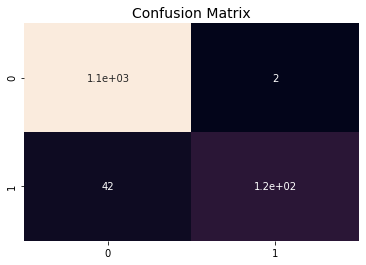

In [ ]:
y_pred = classifier.predict(train_feature)
# print (Y_pred)
cm = confusion_matrix(train_label, y_pred)
print("Confusion Matrix: \n")
print(cm)


df_cm = pd.DataFrame(cm, range(2), range(2))

sns.heatmap(df_cm, annot=True, cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)


## Use probability as input

In [ ]:
# label1 = torch.load('/content/gdrive/My Drive/Crypto/label1.pt')
# label2 = torch.load('/content/gdrive/My Drive/Crypto/label2.pt')
# pred1 = torch.load('/content/gdrive/My Drive/Crypto/pred1.pt')
# pred2 = torch.load('/content/gdrive/My Drive/Crypto/pred2.pt')

In [ ]:
##for gamma =1 
label1 = torch.load('/content/gdrive/My Drive/Crypto/label1_gamma1.pt')
label2 = torch.load('/content/gdrive/My Drive/Crypto/label2_gamma1.pt')
pred1 = torch.load('/content/gdrive/My Drive/Crypto/pred1_gamma1.pt')
pred2 = torch.load('/content/gdrive/My Drive/Crypto/pred2_gamma1.pt')

In [ ]:
m = nn.Softmax(dim=1)
pred1 = m(torch.tensor(pred1))
pred2 = m(torch.tensor(pred2))

In [ ]:

# pred1_SVM = torch.load('/content/gdrive/My Drive/Crypto/pred_proba_SVM1.pt')
# pred2_SVM = torch.load('/content/gdrive/My Drive/Crypto/pred_proba_SVM2.pt')

In [ ]:
#use the probability from decision fuction instead
pred1_SVM = torch.load('/content/gdrive/My Drive/Crypto/y_pred_decision_function_SVM1.pt')
pred2_SVM = torch.load('/content/gdrive/My Drive/Crypto/y_pred_decision_function_SVM2.pt')

In [ ]:
#pred2_SVM[0:30]
#pred2[0:30]

array([-1.69566461, -1.52779352, -2.26270749, -1.40142506, -2.22786551,
       -1.00414713, -1.82971542, -1.41862395, -2.24415991, -1.66380345,
       -1.57640695, -1.11102638, -1.73082027, -0.93504519, -2.14379516,
       -2.21873534, -1.52703926, -1.97525434, -0.40364704, -0.83513212,
       -1.19552458, -1.90555414, -1.53954699, -1.8115804 , -0.85146197,
        0.36401162, -0.26605168, -0.92187519, -0.90449926, -1.75297338])

In [ ]:
## now prepare the features. 
a1 = torch.transpose(pred1,1,0)[1]
a2 = torch.transpose(pred2,1,0)[1]

In [ ]:
pred1_SVM = torch.tensor(pred1_SVM)
pred2_SVM = torch.tensor(pred2_SVM)

In [ ]:
#this is for the proba
# a1_SVM = torch.transpose(pred1_SVM,1,0)[1]
# a2_SVM = torch.transpose(pred2_SVM,1,0)[1]

#for decision function
a1_SVM = torch.sigmoid(pred1_SVM)
a2_SVM = torch.sigmoid(pred2_SVM)

In [ ]:
train_feature = torch.stack((a1,a1_SVM),dim=0)
train_feature = torch.transpose(train_feature,0,1)
val_feature = torch.stack((a2,a2_SVM),dim=0)
val_feature = torch.transpose(val_feature,0,1)

In [ ]:
train_label = torch.tensor(label1)
val_label = torch.tensor(label2)

In [ ]:
#now create dataloader
train_dataset = TensorDataset(train_feature.type(torch.float), train_label)
val_dataset = TensorDataset(val_feature.type(torch.float), val_label)
train_loader = DataLoader(train_dataset, batch_size = 64, )
eval_loader = DataLoader(val_dataset, batch_size = 64, )

### probability with logistic regression

In [ ]:
clf = LogisticRegression()
clf.fit(train_feature,train_label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Confusion Matrix: 

[[1107    0]
 [  26  141]]


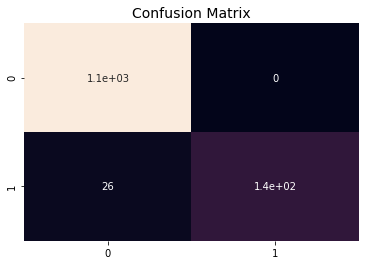

In [ ]:
y_pred = clf.predict(train_feature)
# print (Y_pred)
cm = confusion_matrix(train_label, y_pred)
print("Confusion Matrix: \n")
print(cm)


df_cm = pd.DataFrame(cm, range(2), range(2))

sns.heatmap(df_cm, annot=True, cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)

Confusion Matrix: 

[[474  21]
 [ 42   9]]


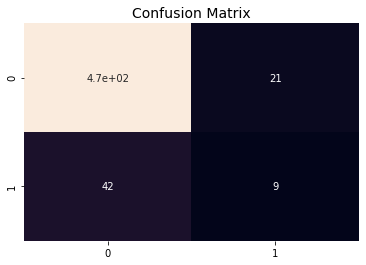

In [ ]:
y_pred = clf.predict(val_feature)
# print (Y_pred)
cm = confusion_matrix(val_label, y_pred)
print("Confusion Matrix: \n")
print(cm)


df_cm = pd.DataFrame(cm, range(2), range(2))

sns.heatmap(df_cm, annot=True, cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)

In [ ]:
torch.save(y_pred,'/content/gdrive/My Drive/Crypto/y_pred_up.pt')

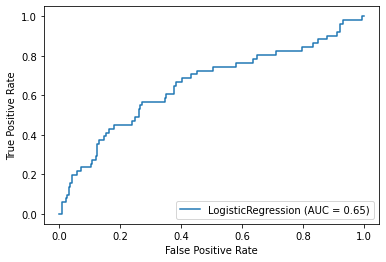

In [ ]:
plot_roc_curve(clf, val_feature, val_label)  

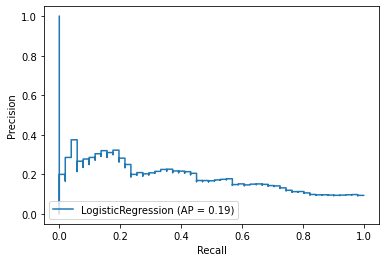

In [ ]:
plot_precision_recall_curve(clf, val_feature, val_label)  

### probability with SVM

In [ ]:
train_feature

tensor([[0.4079, 0.0919],
        [0.3745, 0.2076],
        [0.1596, 0.2689],
        ...,
        [0.4161, 0.1585],
        [0.4459, 0.2074],
        [0.2214, 0.1343]], dtype=torch.float64)

In [ ]:
# Pipeline Steps are StandardScaler, PCA and SVM 
pipe_steps = [('SupVM', SVC(kernel='rbf', ))]

check_params= {
    'SupVM__C': [0.1, 0.5, 1, 10,30, 40, 50, 75, 100, 500, 1000], 
    'SupVM__gamma' : [0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50]
}

pipeline = Pipeline(pipe_steps)

In [ ]:
from tqdm import tqdm_notebook as tqdm 
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")



print ("Start Fitting Training Data")
for cv in tqdm(range(4,5)):
    create_grid = GridSearchCV(pipeline, param_grid=check_params, cv=cv,scoring='f1')
    create_grid.fit(train_feature, train_label)
    print ("score for %d fold CV := %3.2f" %(cv, create_grid.score(val_feature, val_label)))
    print ("!!!!!!!! Best-Fit Parameters From Training Data !!!!!!!!!!!!!!")
    print (create_grid.best_params_)

print ("out of the loop")

Start Fitting Training Data


score for 4 fold CV := 0.30
!!!!!!!! Best-Fit Parameters From Training Data !!!!!!!!!!!!!!
{'SupVM__C': 500, 'SupVM__gamma': 50}

out of the loop


In [ ]:
print ("grid best params: ", create_grid.best_params_) 
# use the best one

grid best params:  {'SupVM__C': 500, 'SupVM__gamma': 50}


Confusion Matrix: 

[[1104    3]
 [   9  158]]


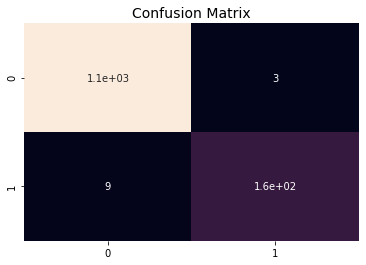

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = create_grid.predict(train_feature)
# print (Y_pred)
cm = confusion_matrix(train_label, y_pred)
print("Confusion Matrix: \n")
print(cm)


df_cm = pd.DataFrame(cm, range(2), range(2))

sns.heatmap(df_cm, annot=True, cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)

Confusion Matrix: 

[[419  76]
 [ 29  22]]


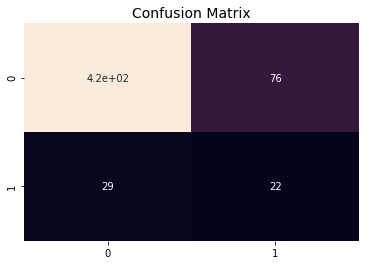

In [ ]:
y_pred = create_grid.predict(val_feature)
# print (Y_pred)
cm = confusion_matrix(val_label, y_pred)
print("Confusion Matrix: \n")
print(cm)


df_cm = pd.DataFrame(cm, range(2), range(2))

sns.heatmap(df_cm, annot=True, cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)

### probability with SVM and polynomial kernel

In [ ]:
pipe_steps = [ ('SupVM', SVC(kernel='poly',C=0.5,gamma=1))]
pipeline = Pipeline(pipe_steps)

In [ ]:
pipeline.fit(train_feature,train_label)

Pipeline(memory=None,
         steps=[('SupVM',
                 SVC(C=0.5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=1, kernel='poly', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

Confusion Matrix: 

[[1107    0]
 [  27  140]]


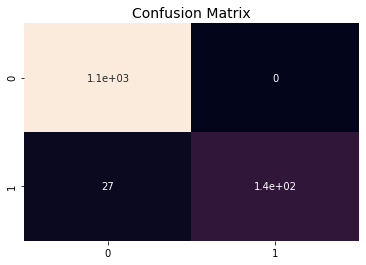

In [ ]:
y_pred = pipeline.predict(train_feature)
# print (Y_pred)
cm = confusion_matrix(train_label, y_pred)
print("Confusion Matrix: \n")
print(cm)


df_cm = pd.DataFrame(cm, range(2), range(2))

sns.heatmap(df_cm, annot=True, cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)

Confusion Matrix: 

[[477  18]
 [ 43   8]]


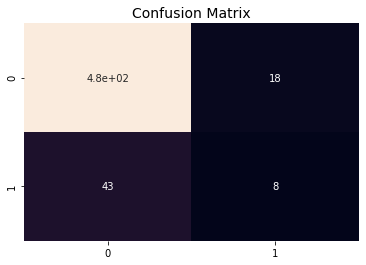

In [ ]:
y_pred = pipeline.predict(val_feature)
# print (Y_pred)
cm = confusion_matrix(val_label, y_pred)
print("Confusion Matrix: \n")
print(cm)


df_cm = pd.DataFrame(cm, range(2), range(2))

sns.heatmap(df_cm, annot=True, cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)

In [ ]:
print (classification_report(val_label,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       495
           1       0.31      0.16      0.21        51

    accuracy                           0.89       546
   macro avg       0.61      0.56      0.57       546
weighted avg       0.86      0.89      0.87       546



In [ ]:
y_pred_decision = pipeline.decision_function(val_feature)

In [ ]:
roc_auc_score(val_label, torch.sigmoid(torch.tensor(y_pred_decision)))

0.6435729847494553

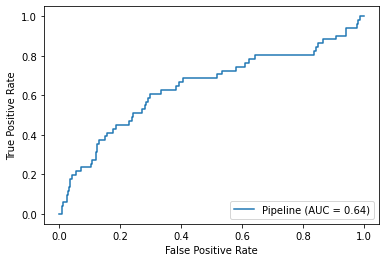

In [ ]:
plot_roc_curve(pipeline, val_feature, val_label)  

In [ ]:
fpr, tpr, thresholds = roc_curve(val_label, torch.tensor(y_pred_decision))

In [ ]:
fpr

array([0.        , 0.0020202 , 0.00808081, 0.00808081, 0.01010101,
       0.01010101, 0.01212121, 0.01212121, 0.02222222, 0.02222222,
       0.02626263, 0.02626263, 0.02828283, 0.02828283, 0.03232323,
       0.03232323, 0.03636364, 0.03636364, 0.03838384, 0.03838384,
       0.05454545, 0.05454545, 0.07272727, 0.07272727, 0.09494949,
       0.09494949, 0.10707071, 0.10707071, 0.11919192, 0.11919192,
       0.12323232, 0.12323232, 0.12525253, 0.12525253, 0.12929293,
       0.12929293, 0.15353535, 0.15353535, 0.15757576, 0.15757576,
       0.18787879, 0.18787879, 0.21818182, 0.21818182, 0.24040404,
       0.24040404, 0.26060606, 0.26060606, 0.27676768, 0.27676768,
       0.28686869, 0.28686869, 0.28888889, 0.28888889, 0.31717172,
       0.31717172, 0.38787879, 0.38787879, 0.4       , 0.4       ,
       0.42424242, 0.42424242, 0.55151515, 0.55151515, 0.57171717,
       0.57171717, 0.62424242, 0.62424242, 0.66060606, 0.66060606,
       0.67676768, 0.67676768, 0.68484848, 0.68484848, 0.75757

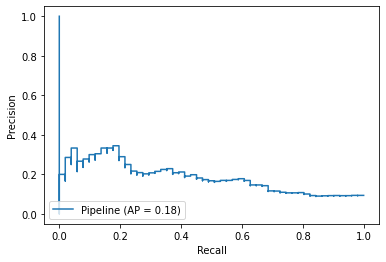

In [ ]:
plot_precision_recall_curve(pipeline, val_feature, val_label)  

In [ ]:
precision, recall, thresholds = precision_recall_curve(val_label, torch.tensor(y_pred_decision))

In [ ]:
precision

array([0.09375   , 0.09208103, 0.09225092, 0.09242144, 0.09259259,
       0.09276438, 0.0929368 , 0.09310987, 0.09328358, 0.09345794,
       0.09363296, 0.09380863, 0.09210526, 0.09227872, 0.09245283,
       0.09073724, 0.09090909, 0.09108159, 0.09125475, 0.09142857,
       0.09160305, 0.0917782 , 0.09195402, 0.09213052, 0.09230769,
       0.09055877, 0.09073359, 0.09090909, 0.09108527, 0.09126214,
       0.09143969, 0.09161793, 0.09179688, 0.09197652, 0.09215686,
       0.09233792, 0.09251969, 0.09270217, 0.09288538, 0.09306931,
       0.09126984, 0.09145129, 0.09163347, 0.09181637, 0.092     ,
       0.09218437, 0.09236948, 0.09255533, 0.09072581, 0.09090909,
       0.09109312, 0.09127789, 0.09146341, 0.09164969, 0.08979592,
       0.08997955, 0.09016393, 0.08829569, 0.08847737, 0.08865979,
       0.08884298, 0.08902692, 0.08921162, 0.08939709, 0.08958333,
       0.08977035, 0.08995816, 0.09014675, 0.09033613, 0.09052632,
       0.0907173 , 0.09090909, 0.09110169, 0.09129512, 0.09148

In [ ]:
f1_score(val_label,y_pred,average="weighted")

0.8737232340226785

In [ ]:
s

NameError: ignored

# Fusion with NN price output


## Use Neural Network

In [ ]:
##so now that data is prepared, I just need to write a NN to train and test. 
#let's first try a simple FC NN
class FFNN (nn.Module):
    def __init__(self, input_size, num_classes,num_hidden, hidden_dim ):
        super().__init__()

        assert num_hidden > 0 

        self.fc1 = nn.Linear(input_size,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)

        self.hidden_layers = nn.ModuleList([])
        self.hidden_layers.append (self.fc1)
        for i in range (num_hidden -1 ):
            self.hidden_layers.append(self.fc2)
        
        self.final_layer = nn.Linear (hidden_dim,num_classes)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self,x):
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.relu(x)
        
        out = self.final_layer(x)
        out_dist = F.log_softmax(out, dim= -1) #why is it -1, ok, coz it's batch x input x class. 

        return out_dist


In [ ]:
INPUT_SIZE = 2
NUM_CLASSES = 2
NUM_HIDDEN = 2
HIDDEN_DIM = 64

model = FFNN(INPUT_SIZE, NUM_CLASSES, NUM_HIDDEN, HIDDEN_DIM)


In [ ]:
model

FFNN(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
  )
  (final_layer): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [ ]:
optimizer = optim.Adam(model.parameters())
loss_fn = nn.NLLLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# loss_fn = loss_fn.to(device)

In [ ]:
#define a function to calcualte prediction accuracy
def accuracy(pred,label):
    _,pred_label = torch.max(pred,dim=1)
    correct = (pred_label==label).float()
    accuracy = correct.sum()/len(correct)
    return accuracy

In [ ]:
#can i define a function to calculate the f1 score/confusion matrix? 
def get_cfm (pred, label):
    m = nn.Softmax(dim=1)
    _,pred_label = torch.max(m(pred),dim=1)
    mm = classification_report(label.cpu(),pred_label.cpu())
    m = confusion_matrix(label.cpu(),pred_label.cpu())
    return mm, m 

In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0
    epoch_acc = 0
    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        #data = data.to(device)
        #label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc  = accuracy(pred,label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc
        #append the prediction result and show it per epoch later. 
        if step ==0:     
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)

        epoch_loss += loss.item()
        epoch_acc += acc

    report1, report2 = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report1, report2)  
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)

In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0 
    epoch_acc = 0 

    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        #data = data.to(device)
        #label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc = accuracy(pred,label)
        
        #append the prediction result and show it per epoch later. 
        if step ==0:     
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)

        epoch_loss += loss.item()
        epoch_acc += acc

    report1, report2 = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report1, report2)  
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)

In [ ]:
N_EPOCHS = 30

for i in range(N_EPOCHS):
    train_loss,train_acc = train(model,train_loader, optimizer, loss_fn)
    
    eval_loss, eval_acc = evaluate(model,eval_loader, loss_fn)
    
    print (f' Epoch Number {i}') 
    print (f' Train. Loss: {train_loss:.3f} Train. Acc: {train_acc*100:.2f}%')
    print (f' Eval loss , {eval_loss:.3f}, eval acc, {eval_acc*100:.2f} %')
    # print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

              precision    recall  f1-score   support

           0       0.87      0.99      0.93      1107
           1       0.25      0.02      0.04       167

    accuracy                           0.86      1274
   macro avg       0.56      0.51      0.48      1274
weighted avg       0.79      0.86      0.81      1274
 [[1095   12]
 [ 163    4]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       495
           1       0.00      0.00      0.00        51

    accuracy                           0.91       546
   macro avg       0.45      0.50      0.48       546
weighted avg       0.82      0.91      0.86       546
 [[495   0]
 [ 51   0]]
 Epoch Number 0
 Train. Loss: 1.095 Train. Acc: 172.61%
 Eval loss , 0.401, eval acc, 90.84 %
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1107
           1       0.00      0.00      0.00       167

    accuracy                          

## Use probability as input

In [ ]:
# label1 = torch.load('/content/gdrive/My Drive/Crypto/label1.pt')
# label2 = torch.load('/content/gdrive/My Drive/Crypto/label2.pt')
# pred1 = torch.load('/content/gdrive/My Drive/Crypto/pred1.pt')
# pred2 = torch.load('/content/gdrive/My Drive/Crypto/pred2.pt')

In [ ]:
##for gamma =1 
label1 = torch.load('/content/gdrive/My Drive/Crypto/label1_gamma1.pt')
label2 = torch.load('/content/gdrive/My Drive/Crypto/label2_gamma1.pt')
pred1 = torch.load('/content/gdrive/My Drive/Crypto/pred1_gamma1.pt')
pred2 = torch.load('/content/gdrive/My Drive/Crypto/pred2_gamma1.pt')

In [ ]:
m = nn.Softmax(dim=1)
pred1 = m(torch.tensor(pred1))
pred2 = m(torch.tensor(pred2))

In [ ]:

label1_price = torch.load('/content/gdrive/My Drive/Crypto/price_label1_g2a025.pt')


In [ ]:
sum(label1 == label1_price)
#meaning that the labels do match. so...

1274

In [ ]:
#use the probability from decision fuction instead
pred1_NN = torch.load('/content/gdrive/My Drive/Crypto/price_pred1_g2a025.pt')
pred2_NN = torch.load('/content/gdrive/My Drive/Crypto/price_pred2_g2a025.pt')

In [ ]:
m = nn.Softmax(dim=1)
pred1_NN = m(torch.tensor(pred1_NN))
pred2_NN = m(torch.tensor(pred2_NN))

In [ ]:
#pred2_SVM[0:30]
#pred2[0:30]

array([-1.69566461, -1.52779352, -2.26270749, -1.40142506, -2.22786551,
       -1.00414713, -1.82971542, -1.41862395, -2.24415991, -1.66380345,
       -1.57640695, -1.11102638, -1.73082027, -0.93504519, -2.14379516,
       -2.21873534, -1.52703926, -1.97525434, -0.40364704, -0.83513212,
       -1.19552458, -1.90555414, -1.53954699, -1.8115804 , -0.85146197,
        0.36401162, -0.26605168, -0.92187519, -0.90449926, -1.75297338])

In [ ]:
## now prepare the features. 
a1 = torch.transpose(pred1,1,0)[1]
a2 = torch.transpose(pred2,1,0)[1]

In [ ]:
a1_price = torch.transpose(pred1_NN,1,0)[1]
a2_price = torch.transpose(pred2_NN,1,0)[1]

In [ ]:
train_feature = torch.stack((a1,a1_price),dim=0)
train_feature = torch.transpose(train_feature,0,1)
val_feature = torch.stack((a2,a2_price),dim=0)
val_feature = torch.transpose(val_feature,0,1)

In [ ]:
sum(a2>0.5)

tensor(251)

In [ ]:
train_label = torch.tensor(label1)
val_label = torch.tensor(label2)

In [ ]:
#now create dataloader
train_dataset = TensorDataset(train_feature.type(torch.float), train_label)
val_dataset = TensorDataset(val_feature.type(torch.float), val_label)
train_loader = DataLoader(train_dataset, batch_size = 64, )
eval_loader = DataLoader(val_dataset, batch_size = 64, )

### probability with logistic regression

In [ ]:
clf = LogisticRegression()
clf.fit(train_feature,train_label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Confusion Matrix: 

[[1107    0]
 [ 166    1]]


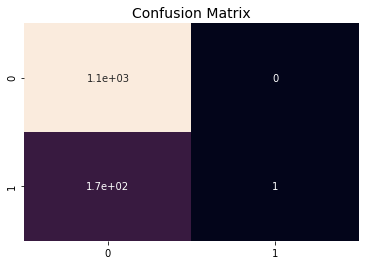

In [ ]:
y_pred = clf.predict(train_feature)
# print (Y_pred)
cm = confusion_matrix(train_label, y_pred)
print("Confusion Matrix: \n")
print(cm)


df_cm = pd.DataFrame(cm, range(2), range(2))

sns.heatmap(df_cm, annot=True, cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)

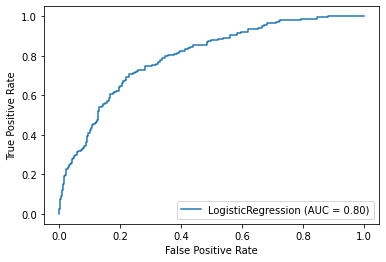

In [ ]:
plot_roc_curve(clf, train_feature, train_label)  

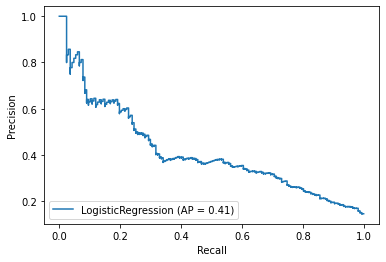

In [ ]:
plot_precision_recall_curve(clf, train_feature, train_label)  

In [ ]:
y_pred_decision = clf.decision_function(train_feature)
precision, recall, thresholds = precision_recall_curve(train_label, torch.tensor(y_pred_decision))

In [ ]:

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, precision =%.3f, recall=%.3f' % (thresholds[ix], fscore[ix],precision[ix],recall[ix]))

Best Threshold=-1.512322, F-Score=0.447, precision =0.354, recall=0.605


Testing out a few different filters. 
Recall rate as filter,
Precision rate as filter,

the above F1 score as filter didn't work very well

In [ ]:
#What if I want to keep recall rate the same, but incrase precision. compared to the price model, say i want recall rate to be 0.29. 
t= (recall>=0.29)
ind_t = [i for i, x in enumerate(t) if x]
t_T = [y for j,y in enumerate(precision[ind_t]) if y>0.24


In [ ]:
precision[ind_t].sort()

In [ ]:
np.argmax(precision[ind_t]),ind_t[990],thresholds[990]

(990, 990, -1.2557311749960416)

In [ ]:
t= (precision>=0.55)
ind_t = [i for i, x in enumerate(t) if x]


In [ ]:
np.argmax(recall[ind_t]),ind_t[0],thresholds[1074]

(0, 1074, -1.0006228959023638)

In [ ]:
y_pred_val_decision=clf.decision_function(val_feature)
y_pred = ( y_pred_val_decision>=  -1.0006228959023638).astype('int')

Confusion Matrix: 

[[459  36]
 [ 36  15]]


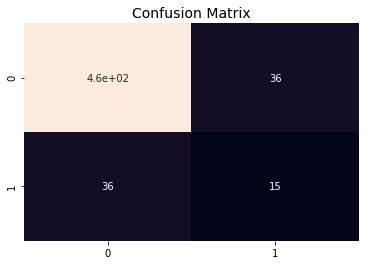

In [ ]:
#y_pred = clf.predict(val_feature)
# print (Y_pred)
cm = confusion_matrix(val_label, y_pred)
print("Confusion Matrix: \n")
print(cm)


df_cm = pd.DataFrame(cm, range(2), range(2))

sns.heatmap(df_cm, annot=True, cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)

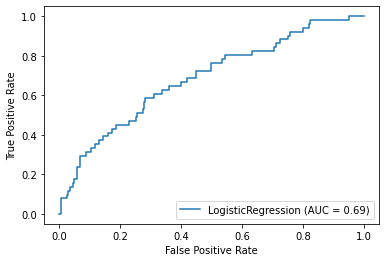

In [ ]:
plot_roc_curve(clf, val_feature, val_label)  

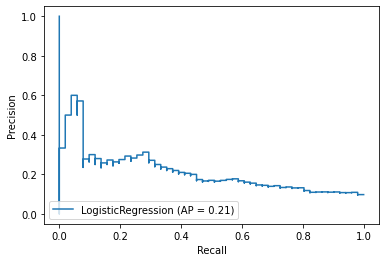

In [ ]:
plot_precision_recall_curve(clf, val_feature, val_label)  

In [ ]:
y_pred_decision = clf.decision_function(val_feature)
precision, recall, thresholds = precision_recall_curve(val_label, torch.tensor(y_pred_decision))

In [ ]:
precision = torch.tensor(precision)
recall = torch.tensor(recall)
thresholds = torch.tensor(thresholds.copy())

In [ ]:
len(precision),len(thresholds)

(520, 519)

In [ ]:
thresholds

### probability with SVM

In [ ]:
train_feature

tensor([[0.3547, 0.3606],
        [0.4581, 0.3403],
        [0.2382, 0.4680],
        ...,
        [0.4529, 0.3331],
        [0.5316, 0.3631],
        [0.3482, 0.3186]])

In [ ]:
# Pipeline Steps are StandardScaler, PCA and SVM 
pipe_steps = [('SupVM', SVC(kernel='rbf', ))]

check_params= {
    'SupVM__C': [0.1, 0.5, 1, 10,30, 40, 50, 75, 100, 500, 1000], 
    'SupVM__gamma' : [0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50]
}

pipeline = Pipeline(pipe_steps)

In [ ]:
from tqdm import tqdm_notebook as tqdm 
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")



print ("Start Fitting Training Data")
for cv in tqdm(range(4,5)):
    create_grid = GridSearchCV(pipeline, param_grid=check_params, cv=cv,scoring='f1_weighted')
    create_grid.fit(train_feature, train_label)
    print ("score for %d fold CV := %3.2f" %(cv, create_grid.score(val_feature, val_label)))
    print ("!!!!!!!! Best-Fit Parameters From Training Data !!!!!!!!!!!!!!")
    print (create_grid.best_params_)

print ("out of the loop")

Start Fitting Training Data


score for 4 fold CV := 0.87
!!!!!!!! Best-Fit Parameters From Training Data !!!!!!!!!!!!!!
{'SupVM__C': 10, 'SupVM__gamma': 50}

out of the loop


In [ ]:
print ("grid best params: ", create_grid.best_params_) 
# use the best one

grid best params:  {'SupVM__C': 10, 'SupVM__gamma': 50}


Confusion Matrix: 

[[1105    2]
 [ 151   16]]


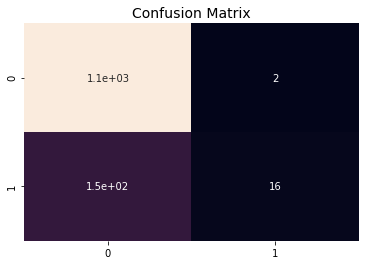

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = create_grid.predict(train_feature)
# print (Y_pred)
cm = confusion_matrix(train_label, y_pred)
print("Confusion Matrix: \n")
print(cm)


df_cm = pd.DataFrame(cm, range(2), range(2))

sns.heatmap(df_cm, annot=True, cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)

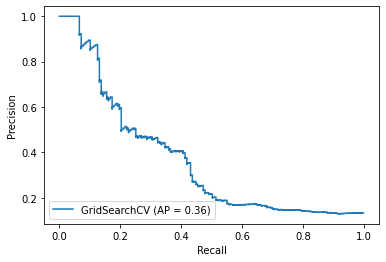

In [ ]:
plot_precision_recall_curve(create_grid, train_feature, train_label)  

In [ ]:
y_pred_decision = create_grid.decision_function(train_feature)
precision, recall, thresholds = precision_recall_curve(train_label, torch.tensor(y_pred_decision))

In [ ]:
t= (precision>=0.55)
ind_t = [i for i, x in enumerate(t) if x]
np.argmax(recall[ind_t]),ind_t[0],thresholds[1186]

(0, 1186, -0.9021578701888217)

In [ ]:
y_pred_val_decision=create_grid.decision_function(val_feature)
y_pred = ( y_pred_val_decision>= -0.9021578701888217).astype('int')

Confusion Matrix: 

[[457  38]
 [ 41  10]]


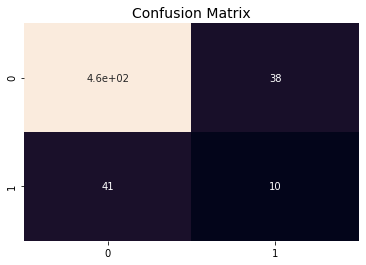

In [ ]:
#y_pred = create_grid.predict(val_feature)
# print (Y_pred)
cm = confusion_matrix(val_label, y_pred)
print("Confusion Matrix: \n")
print(cm)


df_cm = pd.DataFrame(cm, range(2), range(2))

sns.heatmap(df_cm, annot=True, cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)

### probability with SVM and polynomial kernel

In [ ]:
pipe_steps = [ ('SupVM', SVC(kernel='poly',C=100,gamma=2))]
pipeline = Pipeline(pipe_steps)

In [ ]:
pipeline.fit(train_feature,train_label)

Pipeline(memory=None,
         steps=[('SupVM',
                 SVC(C=100, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=2, kernel='poly', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

Confusion Matrix: 

[[1107    0]
 [ 167    0]]


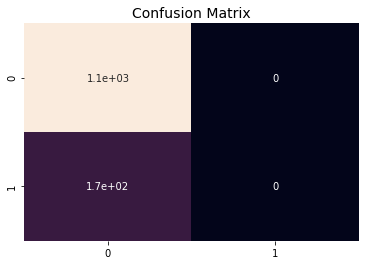

In [ ]:
y_pred = pipeline.predict(train_feature)
# print (Y_pred)
cm = confusion_matrix(train_label, y_pred)
print("Confusion Matrix: \n")
print(cm)


df_cm = pd.DataFrame(cm, range(2), range(2))

sns.heatmap(df_cm, annot=True, cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)

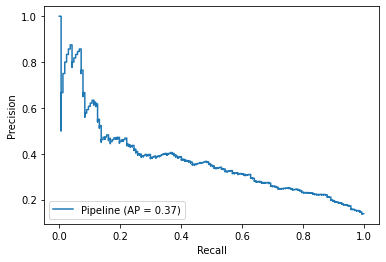

In [ ]:
plot_precision_recall_curve(pipeline, train_feature, train_label)  

In [ ]:
y_pred_decision = pipeline.decision_function(train_feature)
precision, recall, thresholds = precision_recall_curve(train_label, torch.tensor(y_pred_decision))
t= (precision>=0.7)
ind_t = [i for i, x in enumerate(t) if x]
np.argmax(recall[ind_t]),ind_t[0],thresholds[1191]

(0, 1191, -0.9989901088047046)

In [ ]:
y_pred_val_decision=pipeline.decision_function(val_feature)
y_pred = ( y_pred_val_decision>=  -0.9989901088047046).astype('int')

Confusion Matrix: 

[[435  60]
 [ 44   7]]


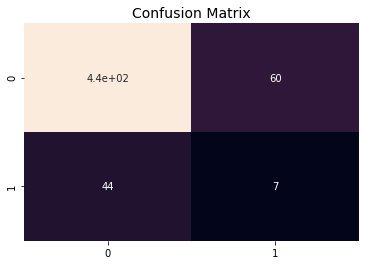

In [ ]:
#y_pred = pipeline.predict(val_feature)
# print (Y_pred)
cm = confusion_matrix(val_label, y_pred)
print("Confusion Matrix: \n")
print(cm)


df_cm = pd.DataFrame(cm, range(2), range(2))

sns.heatmap(df_cm, annot=True, cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)

In [ ]:
print (classification_report(val_label,y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       495
           1       0.00      0.00      0.00        51

    accuracy                           0.91       546
   macro avg       0.45      0.50      0.48       546
weighted avg       0.82      0.91      0.86       546



In [ ]:
y_pred_decision = pipeline.decision_function(val_feature)

In [ ]:
roc_auc_score(val_label, torch.sigmoid(torch.tensor(y_pred_decision)))

0.3479500891265597

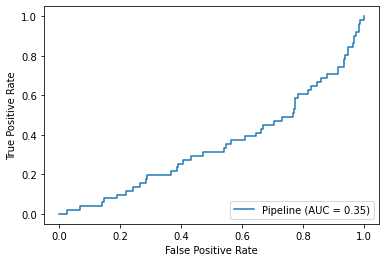

In [ ]:
plot_roc_curve(pipeline, val_feature, val_label)  

In [ ]:
fpr, tpr, thresholds = roc_curve(val_label, torch.tensor(y_pred_decision))

In [ ]:
fpr

array([0.        , 0.0020202 , 0.02626263, 0.02626263, 0.06868687,
       0.06868687, 0.13939394, 0.13939394, 0.14545455, 0.14545455,
       0.18989899, 0.18989899, 0.22020202, 0.22020202, 0.24242424,
       0.24242424, 0.26464646, 0.26464646, 0.28484848, 0.28484848,
       0.28888889, 0.28888889, 0.36767677, 0.36767677, 0.38787879,
       0.38787879, 0.38989899, 0.38989899, 0.40808081, 0.40808081,
       0.43232323, 0.43232323, 0.47272727, 0.47272727, 0.54141414,
       0.54141414, 0.54747475, 0.54747475, 0.56363636, 0.56363636,
       0.61010101, 0.61010101, 0.64646465, 0.64646465, 0.66262626,
       0.66262626, 0.66868687, 0.66868687, 0.70505051, 0.70505051,
       0.73131313, 0.73131313, 0.76767677, 0.76767677, 0.77171717,
       0.77171717, 0.77373737, 0.77373737, 0.77575758, 0.77575758,
       0.78383838, 0.78383838, 0.81818182, 0.81818182, 0.82626263,
       0.82626263, 0.84646465, 0.84646465, 0.86060606, 0.86060606,
       0.87878788, 0.87878788, 0.91717172, 0.91717172, 0.93535

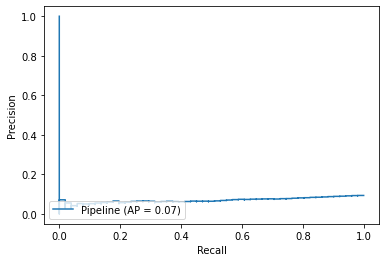

In [ ]:
plot_precision_recall_curve(pipeline, val_feature, val_label)  

In [ ]:
precision, recall, thresholds = precision_recall_curve(val_label, torch.tensor(y_pred_decision))

In [ ]:
precision

array([0.09375   , 0.09208103, 0.09225092, 0.09242144, 0.09259259,
       0.09276438, 0.0929368 , 0.09310987, 0.09328358, 0.09345794,
       0.09363296, 0.09380863, 0.09210526, 0.09227872, 0.09245283,
       0.09073724, 0.09090909, 0.09108159, 0.09125475, 0.09142857,
       0.09160305, 0.0917782 , 0.09195402, 0.09213052, 0.09230769,
       0.09055877, 0.09073359, 0.09090909, 0.09108527, 0.09126214,
       0.09143969, 0.09161793, 0.09179688, 0.09197652, 0.09215686,
       0.09233792, 0.09251969, 0.09270217, 0.09288538, 0.09306931,
       0.09126984, 0.09145129, 0.09163347, 0.09181637, 0.092     ,
       0.09218437, 0.09236948, 0.09255533, 0.09072581, 0.09090909,
       0.09109312, 0.09127789, 0.09146341, 0.09164969, 0.08979592,
       0.08997955, 0.09016393, 0.08829569, 0.08847737, 0.08865979,
       0.08884298, 0.08902692, 0.08921162, 0.08939709, 0.08958333,
       0.08977035, 0.08995816, 0.09014675, 0.09033613, 0.09052632,
       0.0907173 , 0.09090909, 0.09110169, 0.09129512, 0.09148

In [ ]:
f1_score(val_label,y_pred,average="weighted")

0.8737232340226785

In [ ]:
s

NameError: ignored

# Fusion for (DOWNWARDS)


## Use Neural Network

In [ ]:
##so now that data is prepared, I just need to write a NN to train and test. 
#let's first try a simple FC NN
class FFNN (nn.Module):
    def __init__(self, input_size, num_classes,num_hidden, hidden_dim ):
        super().__init__()

        assert num_hidden > 0 

        self.fc1 = nn.Linear(input_size,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)

        self.hidden_layers = nn.ModuleList([])
        self.hidden_layers.append (self.fc1)
        for i in range (num_hidden -1 ):
            self.hidden_layers.append(self.fc2)
        
        self.final_layer = nn.Linear (hidden_dim,num_classes)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self,x):
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.relu(x)
        
        out = self.final_layer(x)
        out_dist = F.log_softmax(out, dim= -1) #why is it -1, ok, coz it's batch x input x class. 

        return out_dist


In [ ]:
INPUT_SIZE = 2
NUM_CLASSES = 2
NUM_HIDDEN = 2
HIDDEN_DIM = 64

model = FFNN(INPUT_SIZE, NUM_CLASSES, NUM_HIDDEN, HIDDEN_DIM)


In [ ]:
model

FFNN(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
  )
  (final_layer): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [ ]:
optimizer = optim.Adam(model.parameters())
loss_fn = nn.NLLLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# loss_fn = loss_fn.to(device)

In [ ]:
#define a function to calcualte prediction accuracy
def accuracy(pred,label):
    _,pred_label = torch.max(pred,dim=1)
    correct = (pred_label==label).float()
    accuracy = correct.sum()/len(correct)
    return accuracy

In [ ]:
#can i define a function to calculate the f1 score/confusion matrix? 
def get_cfm (pred, label):
    m = nn.Softmax(dim=1)
    _,pred_label = torch.max(m(pred),dim=1)
    mm = classification_report(label.cpu(),pred_label.cpu())
    m = confusion_matrix(label.cpu(),pred_label.cpu())
    return mm, m 

In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0
    epoch_acc = 0
    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        #data = data.to(device)
        #label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc  = accuracy(pred,label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc
        #append the prediction result and show it per epoch later. 
        if step ==0:     
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)

        epoch_loss += loss.item()
        epoch_acc += acc

    report1, report2 = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report1, report2)  
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)

In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0 
    epoch_acc = 0 

    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        #data = data.to(device)
        #label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc = accuracy(pred,label)
        
        #append the prediction result and show it per epoch later. 
        if step ==0:     
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)

        epoch_loss += loss.item()
        epoch_acc += acc

    report1, report2 = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report1, report2)  
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)

In [ ]:
N_EPOCHS = 30

for i in range(N_EPOCHS):
    train_loss,train_acc = train(model,train_loader, optimizer, loss_fn)
    
    eval_loss, eval_acc = evaluate(model,eval_loader, loss_fn)
    
    print (f' Epoch Number {i}') 
    print (f' Train. Loss: {train_loss:.3f} Train. Acc: {train_acc*100:.2f}%')
    print (f' Eval loss , {eval_loss:.3f}, eval acc, {eval_acc*100:.2f} %')
    # print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

              precision    recall  f1-score   support

           0       0.87      0.99      0.93      1107
           1       0.25      0.02      0.04       167

    accuracy                           0.86      1274
   macro avg       0.56      0.51      0.48      1274
weighted avg       0.79      0.86      0.81      1274
 [[1095   12]
 [ 163    4]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       495
           1       0.00      0.00      0.00        51

    accuracy                           0.91       546
   macro avg       0.45      0.50      0.48       546
weighted avg       0.82      0.91      0.86       546
 [[495   0]
 [ 51   0]]
 Epoch Number 0
 Train. Loss: 1.095 Train. Acc: 172.61%
 Eval loss , 0.401, eval acc, 90.84 %
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1107
           1       0.00      0.00      0.00       167

    accuracy                          

## Use probability as input

In [ ]:
##for gamma =1 
label1 = torch.load('/content/gdrive/My Drive/Crypto/label1_downward.pt')
label2 = torch.load('/content/gdrive/My Drive/Crypto/label2_downward.pt')
pred1 = torch.load('/content/gdrive/My Drive/Crypto/pred1_downward.pt')
pred2 = torch.load('/content/gdrive/My Drive/Crypto/pred2_downward.pt')

In [ ]:
m = nn.Softmax(dim=1)
pred1 = m(torch.tensor(pred1))
pred2 = m(torch.tensor(pred2))

In [ ]:

label1_price = torch.load('/content/gdrive/My Drive/Crypto/label1_SVM_downward.pt')


In [ ]:
#sum(label1 == label1_price)
#meaning that the labels do match. so...

In [ ]:
label1_price.value_counts()

NameError: ignored

In [ ]:
#use the probability from decision fuction instead
pred1_SVM_down = torch.load('/content/gdrive/My Drive/Crypto/y_pred_decision_function_downward1.pt')
pred2_SVM_down = torch.load('/content/gdrive/My Drive/Crypto/y_pred_decision_function_downward2.pt')

In [ ]:
pred1_SVM_down = torch.tensor(pred1_SVM_down)
pred2_SVM_down = torch.tensor(pred2_SVM_down)

In [ ]:
#pred2_SVM[0:30]
#pred2[0:30]
a1_SVM = torch.sigmoid(pred1_SVM_down)
a2_SVM = torch.sigmoid(pred2_SVM_down)

In [ ]:
## now prepare the features. 
a1 = torch.transpose(pred1,1,0)[1]
a2 = torch.transpose(pred2,1,0)[1]

In [ ]:
train_feature = torch.stack((a1,a1_SVM),dim=0)
train_feature = torch.transpose(train_feature,0,1)
val_feature = torch.stack((a2,a2_SVM),dim=0)
val_feature = torch.transpose(val_feature,0,1)

In [ ]:
sum(a2>0.5)

tensor(522)

In [ ]:
train_label = torch.tensor(label1)
val_label = torch.tensor(label2)

In [ ]:
#now create dataloader
train_dataset = TensorDataset(train_feature.type(torch.float), train_label)
val_dataset = TensorDataset(val_feature.type(torch.float), val_label)
train_loader = DataLoader(train_dataset, batch_size = 64, )
eval_loader = DataLoader(val_dataset, batch_size = 64, )

### probability with logistic regression

In [ ]:
clf = LogisticRegression()
clf.fit(train_feature,train_label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Confusion Matrix: 

[[1109    0]
 [  23  142]]


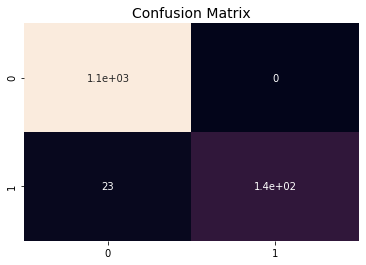

In [ ]:
y_pred = clf.predict(train_feature)
# print (Y_pred)
cm = confusion_matrix(train_label, y_pred)
print("Confusion Matrix: \n")
print(cm)


df_cm = pd.DataFrame(cm, range(2), range(2))

sns.heatmap(df_cm, annot=True, cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)

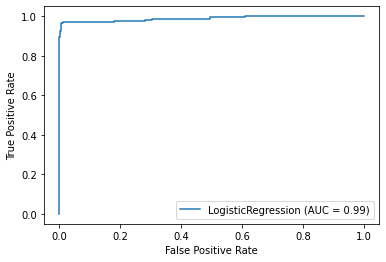

In [ ]:
plot_roc_curve(clf, train_feature, train_label)  

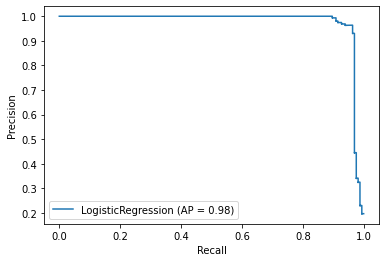

In [ ]:
plot_precision_recall_curve(clf, train_feature, train_label)  

In [ ]:
y_pred_decision = clf.decision_function(train_feature)
precision, recall, thresholds = precision_recall_curve(train_label, torch.tensor(y_pred_decision))

In [ ]:

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, precision =%.3f, recall=%.3f' % (thresholds[ix], fscore[ix],precision[ix],recall[ix]))

Best Threshold=-1.512322, F-Score=0.447, precision =0.354, recall=0.605


Testing out a few different filters. 
Recall rate as filter,
Precision rate as filter,

the above F1 score as filter didn't work very well

In [ ]:
#What if I want to keep recall rate the same, but incrase precision. compared to the price model, say i want recall rate to be 0.29. 
t= (recall>=0.29)
ind_t = [i for i, x in enumerate(t) if x]
t_T = [y for j,y in enumerate(precision[ind_t]) if y>0.24


In [ ]:
precision[ind_t].sort()

In [ ]:
np.argmax(precision[ind_t]),ind_t[990],thresholds[990]

(990, 990, -1.2557311749960416)

In [ ]:
t= (precision>=0.55)
ind_t = [i for i, x in enumerate(t) if x]


In [ ]:
np.argmax(recall[ind_t]),ind_t[0],thresholds[1074]

(0, 1074, -1.0006228959023638)

In [ ]:
y_pred_val_decision=clf.decision_function(val_feature)
y_pred = ( y_pred_val_decision>=  -1.0006228959023638).astype('int')

Confusion Matrix: 

[[463  26]
 [ 45  12]]


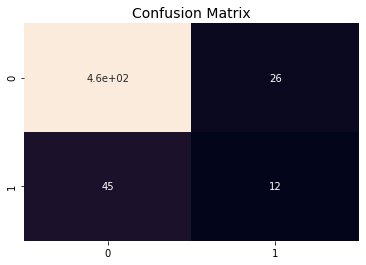

In [ ]:
y_pred = clf.predict(val_feature)
# print (Y_pred)
cm = confusion_matrix(val_label, y_pred)
print("Confusion Matrix: \n")
print(cm)


df_cm = pd.DataFrame(cm, range(2), range(2))

sns.heatmap(df_cm, annot=True, cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)

In [ ]:
torch.save(y_pred,'/content/gdrive/My Drive/Crypto/y_pred_down.pt')

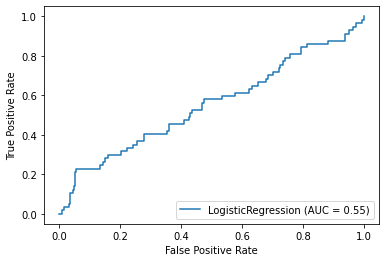

In [ ]:
plot_roc_curve(clf, val_feature, val_label)  

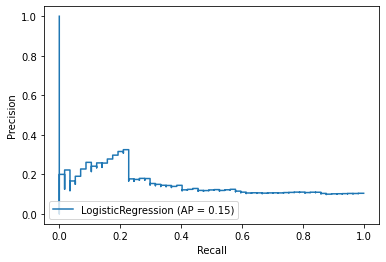

In [ ]:
plot_precision_recall_curve(clf, val_feature, val_label)  

In [ ]:
y_pred_decision = clf.decision_function(val_feature)
precision, recall, thresholds = precision_recall_curve(val_label, torch.tensor(y_pred_decision))

In [ ]:
precision = torch.tensor(precision)
recall = torch.tensor(recall)
thresholds = torch.tensor(thresholds.copy())

In [ ]:
len(precision),len(thresholds)

(520, 519)

In [ ]:
thresholds

### probability with SVM

In [ ]:
train_feature

tensor([[0.4429, 0.2228],
        [0.4534, 0.4516],
        [0.4099, 0.7311],
        ...,
        [0.6562, 0.2690],
        [0.5353, 0.2689],
        [0.4490, 0.1229]], dtype=torch.float64)

In [ ]:
# Pipeline Steps are StandardScaler, PCA and SVM 
pipe_steps = [('SupVM', SVC(kernel='rbf', ))]

check_params= {
    'SupVM__C': [0.1, 0.5, 1, 10,30, 40, 50, 75, 100, 500, 1000], 
    'SupVM__gamma' : [0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50]
}

pipeline = Pipeline(pipe_steps)

In [ ]:
from tqdm import tqdm_notebook as tqdm 
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")



print ("Start Fitting Training Data")
for cv in tqdm(range(4,5)):
    create_grid = GridSearchCV(pipeline, param_grid=check_params, cv=cv,scoring='f1_weighted')
    create_grid.fit(train_feature, train_label)
    print ("score for %d fold CV := %3.2f" %(cv, create_grid.score(val_feature, val_label)))
    print ("!!!!!!!! Best-Fit Parameters From Training Data !!!!!!!!!!!!!!")
    print (create_grid.best_params_)

print ("out of the loop")

Start Fitting Training Data


score for 4 fold CV := 0.77
!!!!!!!! Best-Fit Parameters From Training Data !!!!!!!!!!!!!!
{'SupVM__C': 100, 'SupVM__gamma': 50}

out of the loop


In [ ]:
print ("grid best params: ", create_grid.best_params_) 
# use the best one

grid best params:  {'SupVM__C': 100, 'SupVM__gamma': 50}


Confusion Matrix: 

[[1107    2]
 [   8  157]]


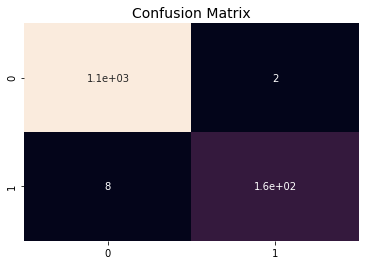

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = create_grid.predict(train_feature)
# print (Y_pred)
cm = confusion_matrix(train_label, y_pred)
print("Confusion Matrix: \n")
print(cm)


df_cm = pd.DataFrame(cm, range(2), range(2))

sns.heatmap(df_cm, annot=True, cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)

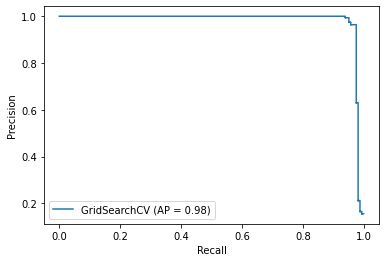

In [ ]:
plot_precision_recall_curve(create_grid, train_feature, train_label)  

In [ ]:
y_pred_decision = create_grid.decision_function(train_feature)
precision, recall, thresholds = precision_recall_curve(train_label, torch.tensor(y_pred_decision))

In [ ]:
t= (precision>=0.55)
ind_t = [i for i, x in enumerate(t) if x]
np.argmax(recall[ind_t]),ind_t[0],thresholds[763]

(0, 763, -1.015248592554597)

In [ ]:
y_pred_val_decision=create_grid.decision_function(val_feature)
y_pred = ( y_pred_val_decision>= -1.015248592554597).astype('int')

Confusion Matrix: 

[[276 213]
 [ 26  31]]


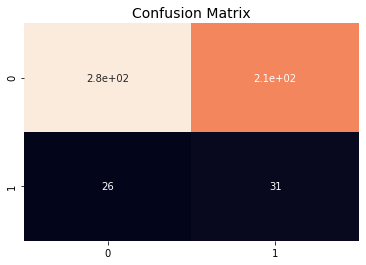

In [ ]:
#y_pred = create_grid.predict(val_feature)
# print (Y_pred)
cm = confusion_matrix(val_label, y_pred)
print("Confusion Matrix: \n")
print(cm)


df_cm = pd.DataFrame(cm, range(2), range(2))

sns.heatmap(df_cm, annot=True, cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)

### probability with SVM and polynomial kernel

In [ ]:
pipe_steps = [ ('SupVM', SVC(kernel='poly',C=100,gamma=2))]
pipeline = Pipeline(pipe_steps)

In [ ]:
pipeline.fit(train_feature,train_label)

Pipeline(memory=None,
         steps=[('SupVM',
                 SVC(C=100, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=2, kernel='poly', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

Confusion Matrix: 

[[1107    0]
 [ 167    0]]


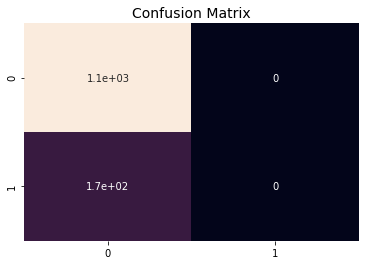

In [ ]:
y_pred = pipeline.predict(train_feature)
# print (Y_pred)
cm = confusion_matrix(train_label, y_pred)
print("Confusion Matrix: \n")
print(cm)


df_cm = pd.DataFrame(cm, range(2), range(2))

sns.heatmap(df_cm, annot=True, cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)

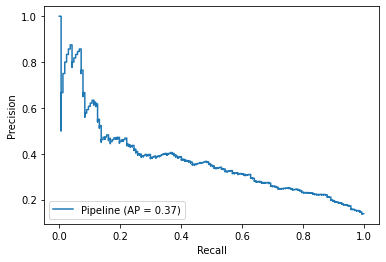

In [ ]:
plot_precision_recall_curve(pipeline, train_feature, train_label)  

In [ ]:
y_pred_decision = pipeline.decision_function(train_feature)
precision, recall, thresholds = precision_recall_curve(train_label, torch.tensor(y_pred_decision))
t= (precision>=0.7)
ind_t = [i for i, x in enumerate(t) if x]
np.argmax(recall[ind_t]),ind_t[0],thresholds[1191]

(0, 1191, -0.9989901088047046)

In [ ]:
y_pred_val_decision=pipeline.decision_function(val_feature)
y_pred = ( y_pred_val_decision>=  -0.9989901088047046).astype('int')

Confusion Matrix: 

[[435  60]
 [ 44   7]]


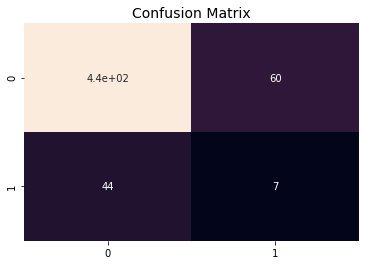

In [ ]:
#y_pred = pipeline.predict(val_feature)
# print (Y_pred)
cm = confusion_matrix(val_label, y_pred)
print("Confusion Matrix: \n")
print(cm)


df_cm = pd.DataFrame(cm, range(2), range(2))

sns.heatmap(df_cm, annot=True, cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)

In [ ]:
print (classification_report(val_label,y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       495
           1       0.00      0.00      0.00        51

    accuracy                           0.91       546
   macro avg       0.45      0.50      0.48       546
weighted avg       0.82      0.91      0.86       546



In [ ]:
y_pred_decision = pipeline.decision_function(val_feature)

In [ ]:
roc_auc_score(val_label, torch.sigmoid(torch.tensor(y_pred_decision)))

0.3479500891265597

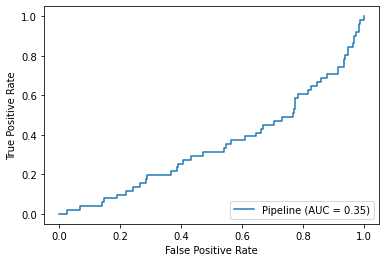

In [ ]:
plot_roc_curve(pipeline, val_feature, val_label)  

In [ ]:
fpr, tpr, thresholds = roc_curve(val_label, torch.tensor(y_pred_decision))

In [ ]:
fpr

array([0.        , 0.0020202 , 0.02626263, 0.02626263, 0.06868687,
       0.06868687, 0.13939394, 0.13939394, 0.14545455, 0.14545455,
       0.18989899, 0.18989899, 0.22020202, 0.22020202, 0.24242424,
       0.24242424, 0.26464646, 0.26464646, 0.28484848, 0.28484848,
       0.28888889, 0.28888889, 0.36767677, 0.36767677, 0.38787879,
       0.38787879, 0.38989899, 0.38989899, 0.40808081, 0.40808081,
       0.43232323, 0.43232323, 0.47272727, 0.47272727, 0.54141414,
       0.54141414, 0.54747475, 0.54747475, 0.56363636, 0.56363636,
       0.61010101, 0.61010101, 0.64646465, 0.64646465, 0.66262626,
       0.66262626, 0.66868687, 0.66868687, 0.70505051, 0.70505051,
       0.73131313, 0.73131313, 0.76767677, 0.76767677, 0.77171717,
       0.77171717, 0.77373737, 0.77373737, 0.77575758, 0.77575758,
       0.78383838, 0.78383838, 0.81818182, 0.81818182, 0.82626263,
       0.82626263, 0.84646465, 0.84646465, 0.86060606, 0.86060606,
       0.87878788, 0.87878788, 0.91717172, 0.91717172, 0.93535

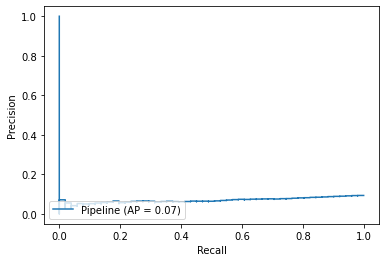

In [ ]:
plot_precision_recall_curve(pipeline, val_feature, val_label)  

In [ ]:
precision, recall, thresholds = precision_recall_curve(val_label, torch.tensor(y_pred_decision))

In [ ]:
precision

array([0.09375   , 0.09208103, 0.09225092, 0.09242144, 0.09259259,
       0.09276438, 0.0929368 , 0.09310987, 0.09328358, 0.09345794,
       0.09363296, 0.09380863, 0.09210526, 0.09227872, 0.09245283,
       0.09073724, 0.09090909, 0.09108159, 0.09125475, 0.09142857,
       0.09160305, 0.0917782 , 0.09195402, 0.09213052, 0.09230769,
       0.09055877, 0.09073359, 0.09090909, 0.09108527, 0.09126214,
       0.09143969, 0.09161793, 0.09179688, 0.09197652, 0.09215686,
       0.09233792, 0.09251969, 0.09270217, 0.09288538, 0.09306931,
       0.09126984, 0.09145129, 0.09163347, 0.09181637, 0.092     ,
       0.09218437, 0.09236948, 0.09255533, 0.09072581, 0.09090909,
       0.09109312, 0.09127789, 0.09146341, 0.09164969, 0.08979592,
       0.08997955, 0.09016393, 0.08829569, 0.08847737, 0.08865979,
       0.08884298, 0.08902692, 0.08921162, 0.08939709, 0.08958333,
       0.08977035, 0.08995816, 0.09014675, 0.09033613, 0.09052632,
       0.0907173 , 0.09090909, 0.09110169, 0.09129512, 0.09148

In [ ]:
f1_score(val_label,y_pred,average="weighted")

0.8737232340226785

In [ ]:
s

NameError: ignored

# backtesting with vectorbt

In [ ]:
#first, load in the predup and pred down
pred_up = torch.load('/content/gdrive/My Drive/Crypto/y_pred_up.pt')
pred_down = torch.load('/content/gdrive/My Drive/Crypto/y_pred_down.pt')

In [ ]:
len(pred_up)

546

In [ ]:
fusion_price = pd.read_csv('/content/gdrive/My Drive/Crypto/price_2015_2019_downward.csv')

In [ ]:
fusion_price[-546:].tail()
#2 days missing: 2018-07-20, 2018-12-31

,Date,Open,High,Low_x,Close,Adj Close,Volume,Low_y,change
1815,2019-12-27,7238.141113,7363.529297,7189.934082,7290.088379,7290.088379,22777360996,7286.905273,-0.000437
1816,2019-12-28,7289.031250,7399.041016,7286.905273,7317.990234,7317.990234,21365673026,7279.865234,-0.005210
1817,2019-12-29,7317.647461,7513.948242,7279.865234,7422.652832,7422.652832,22445257702,7276.308105,-0.019716
1818,2019-12-30,7420.272949,7454.824219,7276.308105,7292.995117,7292.995117,22874131672,7169.777832,-0.016895
1819,2019-12-31,7294.438965,7335.290039,7169.777832,7193.599121,7193.599121,21167946112,7174.944336,-0.002593


In [ ]:
import vectorbt as vbt
start_date ='2018-07-02'
end_date = '2019-12-31'
#price = yf.download("BTC-USD", start=start_date, end=end_date)
price = vbt.YFData.download('BTC-USD', start=start_date, end=end_date).get('Close')
#so the price intake here is a panda.series.
price.shape

(548,)

In [ ]:
price_dropped= price.drop([datetime.datetime(2018,7,20),datetime.datetime(2018,12,31)])

In [ ]:

portfolio = vbt.Portfolio.from_holding(price_dropped, init_cash=100)
#what options are inside portfolio? :https://github.com/polakowo/vectorbt/blob/master/vectorbt/portfolio/base.py
portfolio.total_profit()

8.760253423910697

In [ ]:
type(price)

pandas.core.series.Series

In [ ]:
price.tail()

Date
2019-12-27    7290.088379
2019-12-28    7317.990234
2019-12-29    7422.652832
2019-12-30    7292.995117
2019-12-31    7193.599121
Freq: D, Name: Close, dtype: float64

In [ ]:
fast_ma = vbt.MA.run(price, 10)
slow_ma = vbt.MA.run(price, 50)
entries = fast_ma.ma_above(slow_ma, crossover=True)
exits = fast_ma.ma_below(slow_ma, crossover=True)

portfolio_kwargs = dict(size=np.inf, fees=0.001, freq='1D')
portfolio = vbt.Portfolio.from_signals(price, entries, exits, init_cash=100, **portfolio_kwargs)
portfolio.total_profit()

54.88018164053517

In [ ]:
#with my updated price series. 
fast_ma = vbt.MA.run(price_dropped, 10)
slow_ma = vbt.MA.run(price_dropped, 50)
entries = fast_ma.ma_above(slow_ma, crossover=True)
exits = fast_ma.ma_below(slow_ma, crossover=True)

portfolio_kwargs = dict(size=np.inf, fees=0.001, freq='1D')
portfolio = vbt.Portfolio.from_signals(price_dropped, entries, exits, init_cash=100, **portfolio_kwargs)
portfolio.total_profit()

54.66502380314023

In [ ]:
#now try to define my own buy/sell signal. 
pred_up_frame = pd.DataFrame(pred_up,index=entries.index,)
my_entries = pred_up_frame.squeeze()
pred_down_frame = pd.DataFrame(pred_down,index=exits.index,)
my_exits = pred_down_frame.squeeze()

In [ ]:
my_entries.value_counts(), my_exits.value_counts()

(0    516
 1     30
 Name: 0, dtype: int64, 0    508
 1     38
 Name: 0, dtype: int64)

In [ ]:
entries

Date
2018-07-02    False
2018-07-03    False
2018-07-04    False
2018-07-05    False
2018-07-06    False
              ...  
2019-12-27    False
2019-12-28    False
2019-12-29    False
2019-12-30    False
2019-12-31    False
Length: 546, dtype: bool

In [ ]:
portfolio.stats()
#what is the benchmark return???

Start                            2018-07-02 00:00:00
End                              2019-12-31 00:00:00
Duration                           546 days 00:00:00
Init. Cash                                       100
Total Profit                                  54.665
Total Return [%]                              54.665
Benchmark Return [%]                         8.76025
Position Coverage [%]                        37.1795
Max. Drawdown [%]                            40.0893
Avg. Drawdown [%]                            10.0191
Max. Drawdown Duration             214 days 00:00:00
Avg. Drawdown Duration    42 days 06:32:43.636363636
Num. Trades                                        7
Win Rate [%]                                 14.2857
Best Trade [%]                               152.777
Worst Trade [%]                             -13.5095
Avg. Trade [%]                               15.2028
Max. Trade Duration                157 days 00:00:00
Avg. Trade Duration                 29 days 00

In [ ]:
portfolio.plot().show()
#for MA crossover

In [ ]:
#what data format is the fast_ma/slow_ma: https://github.com/polakowo/vectorbt/blob/master/vectorbt/indicators/basic.py
#entries/exits are also pandan.series. 
# so it's a class? i can see the value from fast_ma.ma
fast_ma.ma

Date
2014-09-17             NaN
2014-09-18             NaN
2014-09-19             NaN
2014-09-20             NaN
2014-09-21             NaN
                  ...     
2021-04-16    60400.950000
2021-04-17    60864.438281
2021-04-18    60653.661328
2021-04-19    60401.587500
2021-04-20    59955.381641
Name: (10, Close), Length: 2404, dtype: float64

In [ ]:
portfolio_kwargs = dict(size=np.inf, fees=0.001, freq='1D')
portfolio = vbt.Portfolio.from_signals(price_dropped, my_entries, my_exits, init_cash=100,conflict_mode='ignore', **portfolio_kwargs)
portfolio.total_profit()
#if conflict_mode is unset, what happens:https://github.com/polakowo/vectorbt/blob/master/vectorbt/portfolio/enums.py
#possible argumetns including entry exit ignore opposite
#use entry > ma strategy > exit in terms of profit, but would lose out on the win rate, but i guess win bigger? 

52.17835504599665

In [ ]:
portfolio.stats()

Start                            2018-07-02 00:00:00
End                              2019-12-31 00:00:00
Duration                           546 days 00:00:00
Init. Cash                                       100
Total Profit                                 52.1784
Total Return [%]                             52.1784
Benchmark Return [%]                         8.76025
Position Coverage [%]                        24.9084
Max. Drawdown [%]                            37.7021
Avg. Drawdown [%]                            11.3746
Max. Drawdown Duration             293 days 00:00:00
Avg. Drawdown Duration    71 days 13:42:51.428571428
Num. Trades                                       15
Win Rate [%]                                      60
Best Trade [%]                               63.3776
Worst Trade [%]                             -22.8505
Avg. Trade [%]                               4.83671
Max. Trade Duration                 34 days 00:00:00
Avg. Trade Duration                  9 days 01

In [ ]:
portfolio.plot().show()
#for my entry/exit inputs

In [ ]:
n = np.random.randint(10, 101, size=15).tolist()
portfolio_kwargs = dict(size=np.inf, fees=0.001, freq='1D')
portfolio = vbt.Portfolio.from_random_signals(price_dropped, n=n, init_cash=100, seed=42,**portfolio_kwargs)

In [ ]:
portfolio.stats()
#for random 

/usr/local/lib/python3.7/dist-packages/vectorbt/utils/decorators.py:270: UserWarning:

Taking mean across columns. To return a DataFrame, pass agg_func=None.



Start                             2018-07-02 00:00:00
End                               2019-12-31 00:00:00
Duration                            546 days 00:00:00
Init. Cash                                        100
Total Profit                                  15.6221
Total Return [%]                              15.6221
Benchmark Return [%]                          8.76025
Position Coverage [%]                         48.9621
Max. Drawdown [%]                             45.6804
Avg. Drawdown [%]                             17.4453
Max. Drawdown Duration              338 days 12:48:00
Avg. Drawdown Duration    128 days 16:45:21.503759400
Num. Trades                                   57.8667
Win Rate [%]                                  49.5686
Best Trade [%]                                 33.967
Worst Trade [%]                              -19.8953
Avg. Trade [%]                               0.897795
Max. Trade Duration                  24 days 01:36:00
Avg. Trade Duration         

## language model signal only

In [ ]:
#first, load in the predup and pred down
pred_up = torch.load('/content/gdrive/My Drive/Crypto/pred2_gamma1.pt')
pred_down = torch.load('/content/gdrive/My Drive/Crypto/pred2_downward.pt')

In [ ]:
len(pred_up) == len(pred_down)

True

In [ ]:
m = nn.Softmax(dim=1)
pred_up = m(torch.tensor(pred_up))
pred_down = m(torch.tensor(pred_down))

In [ ]:
pred_up

tensor([[0.6045, 0.3955],
        [0.5252, 0.4748],
        [0.6586, 0.3414],
        ...,
        [0.4445, 0.5555],
        [0.4477, 0.5523],
        [0.4701, 0.5299]])

In [ ]:
a1 = torch.transpose(pred_up,1,0)[1]
a2 = torch.transpose(pred_down,1,0)[1]

In [ ]:
my_entry = a1>0.5
my_exit = a2>0.5

In [ ]:
my_exit

tensor([False,  True, False, False,  True,  True, False, False, False, False,
        False, False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False,  True, False, False,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True, False,  True, 

In [ ]:
import vectorbt as vbt
start_date ='2018-07-02'
end_date = '2019-12-31'
#price = yf.download("BTC-USD", start=start_date, end=end_date)
price = vbt.YFData.download('BTC-USD', start=start_date, end=end_date).get('Close')
#so the price intake here is a panda.series.
price_dropped= price.drop([datetime.datetime(2018,7,20),datetime.datetime(2018,12,31)])

In [ ]:
#now try to define my own buy/sell signal. 
pred_up_frame = pd.DataFrame(my_entry,index=price_dropped.index,)
my_entries = pred_up_frame.squeeze()
pred_down_frame = pd.DataFrame(my_exit,index=price_dropped.index,)
my_exits = pred_down_frame.squeeze()

In [ ]:
my_entries.value_counts()

False    295
True     251
Name: 0, dtype: int64

In [ ]:
my_exits.value_counts()

True     522
False     24
Name: 0, dtype: int64

In [ ]:
portfolio_kwargs = dict(size=np.inf, fees=0.001, freq='1D')
portfolio = vbt.Portfolio.from_signals(price_dropped, my_entries, my_exits, init_cash=100,conflict_mode='entry', **portfolio_kwargs)
portfolio.total_profit()

-27.71004587976043

In [ ]:
portfolio.stats()

Start                            2018-07-02 00:00:00
End                              2019-12-31 00:00:00
Duration                           546 days 00:00:00
Init. Cash                                       100
Total Profit                                  -27.71
Total Return [%]                              -27.71
Benchmark Return [%]                         8.76025
Position Coverage [%]                        45.9707
Max. Drawdown [%]                            61.1623
Avg. Drawdown [%]                            14.9134
Max. Drawdown Duration             188 days 00:00:00
Avg. Drawdown Duration    60 days 20:34:17.142857143
Num. Trades                                       69
Win Rate [%]                                 46.3768
Best Trade [%]                               20.2112
Worst Trade [%]                             -20.5835
Avg. Trade [%]                             -0.228696
Max. Trade Duration                 17 days 00:00:00
Avg. Trade Duration        3 days 07:18:15.652

In [ ]:
portfolio.plot().show()

## price model signal only

In [ ]:
#first, load in the predup and pred down
pred_up = torch.load('/content/gdrive/My Drive/Crypto/y_pred_decision_function_SVM2.pt')
pred_down = torch.load('/content/gdrive/My Drive/Crypto/y_pred_decision_function_downward2.pt')

In [ ]:
pred_up = torch.sigmoid(torch.tensor(pred_up))
pred_down = torch.sigmoid(torch.tensor(pred_down))

In [ ]:
sum(pred_down>0.5)

tensor(41)

In [ ]:
import vectorbt as vbt
start_date ='2018-07-02'
end_date = '2019-12-31'
#price = yf.download("BTC-USD", start=start_date, end=end_date)
price = vbt.YFData.download('BTC-USD', start=start_date, end=end_date).get('Close')
#so the price intake here is a panda.series.
price_dropped= price.drop([datetime.datetime(2018,7,20),datetime.datetime(2018,12,31)])

In [ ]:
my_entry = pred_up>0.5
my_exit = pred_down>0.5

In [ ]:
#now try to define my own buy/sell signal. 
pred_up_frame = pd.DataFrame(my_entry,index=price_dropped.index,)
my_entries = pred_up_frame.squeeze()
pred_down_frame = pd.DataFrame(my_exit,index=price_dropped.index,)
my_exits = pred_down_frame.squeeze()

In [ ]:
portfolio_kwargs = dict(size=np.inf, fees=0.001, freq='1D')
portfolio = vbt.Portfolio.from_signals(price_dropped, my_entries, my_exits, init_cash=100,conflict_mode="entry", **portfolio_kwargs)
portfolio.total_profit()

99.55813919785217

In [ ]:
portfolio.stats()

Start                            2018-07-02 00:00:00
End                              2019-12-31 00:00:00
Duration                           546 days 00:00:00
Init. Cash                                       100
Total Profit                                 99.5581
Total Return [%]                             99.5581
Benchmark Return [%]                         8.76025
Position Coverage [%]                        53.1136
Max. Drawdown [%]                            39.1913
Avg. Drawdown [%]                            12.2292
Max. Drawdown Duration             278 days 00:00:00
Avg. Drawdown Duration              55 days 21:20:00
Num. Trades                                       21
Win Rate [%]                                  52.381
Best Trade [%]                               63.3776
Worst Trade [%]                              -21.913
Avg. Trade [%]                                4.8887
Max. Trade Duration                 96 days 00:00:00
Avg. Trade Duration       13 days 19:25:42.857

In [ ]:
portfolio.plot().show()

## mix language model buy and price model sell signal

In [ ]:
pred_up = torch.load('/content/gdrive/My Drive/Crypto/pred2_gamma1.pt')
pred_down = torch.load('/content/gdrive/My Drive/Crypto/y_pred_decision_function_downward2.pt')

In [ ]:
m = nn.Softmax(dim=1)
pred_up = m(torch.tensor(pred_up))
a1 = torch.transpose(pred_up,1,0)[1]
my_entry = a1>0.5

In [ ]:
pred_down = torch.sigmoid(torch.tensor(pred_down))
my_exit = pred_down>0.5

In [ ]:
import vectorbt as vbt
start_date ='2018-07-02'
end_date = '2019-12-31'
#price = yf.download("BTC-USD", start=start_date, end=end_date)
price = vbt.YFData.download('BTC-USD', start=start_date, end=end_date).get('Close')
#so the price intake here is a panda.series.
price_dropped= price.drop([datetime.datetime(2018,7,20),datetime.datetime(2018,12,31)])

In [ ]:
pred_up_frame = pd.DataFrame(my_entry,index=price_dropped.index,)
my_entries = pred_up_frame.squeeze()
pred_down_frame = pd.DataFrame(my_exit,index=price_dropped.index,)
my_exits = pred_down_frame.squeeze()

In [ ]:
my_entries.value_counts()

False    295
True     251
Name: 0, dtype: int64

In [ ]:
my_exits.value_counts()

False    505
True      41
Name: 0, dtype: int64

In [ ]:
portfolio_kwargs = dict(size=np.inf, fees=0.001, freq='1D')
portfolio = vbt.Portfolio.from_signals(price_dropped, my_entries, my_exits, init_cash=100,conflict_mode="exit", **portfolio_kwargs)
portfolio.total_profit()

38.731026278667684

In [ ]:
portfolio.stats()

Start                            2018-07-02 00:00:00
End                              2019-12-31 00:00:00
Duration                           546 days 00:00:00
Init. Cash                                       100
Total Profit                                  38.731
Total Return [%]                              38.731
Benchmark Return [%]                         8.76025
Position Coverage [%]                         68.315
Max. Drawdown [%]                            47.4519
Avg. Drawdown [%]                            10.4366
Max. Drawdown Duration             177 days 00:00:00
Avg. Drawdown Duration    32 days 14:46:09.230769230
Num. Trades                                       19
Win Rate [%]                                 57.8947
Best Trade [%]                               54.4443
Worst Trade [%]                              -33.086
Avg. Trade [%]                               4.07341
Max. Trade Duration                 93 days 00:00:00
Avg. Trade Duration       17 days 22:44:12.631

In [ ]:
portfolio.plot().show()